# Mount Collab and CD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/KFUPM Study Material/Term 3 (251 - 2025)/ICS-590/crypto-forecasting-public/big-datasets

/content/drive/MyDrive/KFUPM Study Material/Term 3 (251 - 2025)/ICS-590/crypto-forecasting-public/big-datasets


# Setup

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, mean_absolute_error, mean_squared_error as sk_mse

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

try:
    import ta
except ImportError:
    ta = None
    print("!pip install ta")

SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

pd.set_option("display.max_columns", 200)

Optional: install 'ta' if you want more technical indicators: !pip install ta


In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=a41c084c7f8ef0202cff5623389eafe140c1c26f0e8a6377f93f4178bf9fce7e
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


# CONFIG – FILE PATHS

In [ ]:
CONFIG = {
    "btc_price": "btc_data.parquet",
    "eth_price": "eth_data.parquet",
    "btc_news": "btc_news_data.parquet.gzip",
    "eth_news": "eth_news_data.parquet.gzip",
    "google_trends": "google_trends.parquet.gzip",
    "yahoo_finance": "yf_data.parquet.gzip",
}

for k, v in CONFIG.items():
    if not os.path.exists(v):
        print(f"[WARNING] File for {k} not found at path: {v}")

# LOADER FUNCTIONS

In [ ]:
def load_kaggle_ohlcv(path):
    df = pd.read_parquet(path)
    df["date"] = pd.to_datetime(df["End"])
    df = df.set_index("date").sort_index()
    df = df.rename(columns={"Open": "open","High": "high","Low": "low","Close": "close","Volume": "volume","Market Cap": "market_cap"})

    df = df[["open", "high", "low", "close", "volume", "market_cap"]].astype(float)
    return df


def load_news_single(path, coin):
    df = pd.read_parquet(path)
    df["date"] = pd.to_datetime(df["datetime"]).dt.tz_convert(None).dt.normalize()
    df["coin"] = coin
    df = df[["date", "title", "coin"]].copy()
    df = df.sort_values("date")
    return df

def aggregate_news_features(btc_news_path, eth_news_path):
    btc_news = load_news_single(btc_news_path, "BTC")
    eth_news = load_news_single(eth_news_path, "ETH")
    news = pd.concat([btc_news, eth_news], axis=0, ignore_index=True)
    news["title"] = news["title"].astype(str)
    news["title_len"] = news["title"].str.len()
    bullish = ["rise", "rally", "gain", "soar", "surge", "bull", "record high"]
    bearish = ["fall", "drop", "crash", "plunge", "bear", "selloff", "dump"]

    def simple_sent(s: str) -> int:
        s = s.lower()
        bpos = sum(w in s for w in bullish)
        bneg = sum(w in s for w in bearish)
        return bpos - bneg

    news["sent_simple"] = news["title"].map(simple_sent)
    daily = (news.groupby(["coin", "date"]).agg(news_count=("title", "count"),title_len_mean=("title_len", "mean"),sent_mean=("sent_simple", "mean"),sent_std=("sent_simple", "std")).reset_index())
    return daily

def load_trends(path):
    df = pd.read_parquet(path)

    if "Day" in df.columns:
        df["date"] = pd.to_datetime(df["Day"])
        df = df.set_index("date").drop(columns=["Day"])
    else:
        if df.index.name is None:
            df = df.rename_axis("date")
        else:
            df = df.rename_axis("date")

        df = df.reset_index()
        df["date"] = pd.to_datetime(df["date"])
        df = df.set_index("date")

    df = df.sort_index()
    return df


def load_yahoo_macros(path):
    df = pd.read_parquet(path)

    if "Date" in df.columns:
        df["date"] = pd.to_datetime(df["Date"])
        df = df.set_index("date").drop(columns=["Date"])
    else:
        df = df.rename_axis("date").reset_index()
        df["date"] = pd.to_datetime(df["date"])
        df = df.set_index("date")

    df = df.sort_index()
    return df

## Loader Functions Tester

In [ ]:
# ================= TEST: LOADER FUNCTIONS =================

print("=== Testing loaders with CONFIG ===")

# BTC / ETH price
btc_px = load_kaggle_ohlcv(CONFIG["btc_price"])
eth_px = load_kaggle_ohlcv(CONFIG["eth_price"])

print("\n[BTC] price head:")
print(btc_px.head(3))
print("Index name:", btc_px.index.name, "dtype:", type(btc_px.index[0]))
print("Columns:", btc_px.columns.tolist())

print("\n[ETH] price head:")
print(eth_px.head(3))
print("Index name:", eth_px.index.name, "dtype:", type(eth_px.index[0]))
print("Columns:", eth_px.columns.tolist())

# News
btc_news = load_news_single(CONFIG["btc_news"], "BTC")
eth_news = load_news_single(CONFIG["eth_news"], "ETH")

print("\n[BTC news] head:")
print(btc_news.head(3))
print(btc_news.dtypes)

print("\n[ETH news] head:")
print(eth_news.head(3))
print(eth_news.dtypes)

# Aggregated news
news_daily = aggregate_news_features(CONFIG["btc_news"], CONFIG["eth_news"])
print("\n[News aggregated] head:")
print(news_daily.head(5))
print(news_daily.dtypes)

# Trends
tr_raw = load_trends(CONFIG["google_trends"])
print("\n[Trends] head:")
print(tr_raw.head(3))
print("Index name:", tr_raw.index.name, "dtype:", type(tr_raw.index[0]))

# Yahoo Finance
yh_raw = load_yahoo_macros(CONFIG["yahoo_finance"])
print("\n[Yahoo macro] head:")
print(yh_raw.head(3))
print("Index name:", yh_raw.index.name, "dtype:", type(yh_raw.index[0]))

# Sanity checks
assert btc_px.index.is_monotonic_increasing
assert eth_px.index.is_monotonic_increasing
assert tr_raw.index.is_monotonic_increasing
assert yh_raw.index.is_monotonic_increasing

print("\n[OK] Loader functions passed basic sanity checks.")


=== Testing loaders with CONFIG ===

[BTC] price head:
              open    high     low   close  volume  market_cap
date                                                          
2010-07-18  0.0500  0.0500  0.0500  0.0500     0.0         0.0
2010-07-19  0.0858  0.0858  0.0858  0.0858     0.0         0.0
2010-07-20  0.0808  0.0808  0.0808  0.0808     0.0         0.0
Index name: date dtype: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Columns: ['open', 'high', 'low', 'close', 'volume', 'market_cap']

[ETH] price head:
                open      high       low     close         volume  \
date                                                                
2015-08-09  2.772120  2.798810  0.714725  0.714876  314143.614583   
2015-08-10  0.753325  0.879810  0.629191  0.729347  699826.371528   
2015-08-11  0.701897  0.729854  0.636546  0.707703  457747.909722   

              market_cap  
date                      
2015-08-09  1.039569e+08  
2015-08-10  4.156260e+07  
2015-08-11  4.18

In [ ]:
# After adjusting load_news_big:

news_all = load_news_big(
    CONFIG["btc_news"],
    CONFIG["eth_news"],
)

print("News index type:", type(news_all.index))
print("News index tz:", getattr(news_all.index, "tz", None))

assert isinstance(news_all.index, pd.DatetimeIndex)
assert news_all.index.tz is None, "News index is still tz-aware!"


News index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
News index tz: None


# PRICE-BASED FEATURES & TARGETS

In [ ]:
def add_price_features(df):
    df = df.copy()
    df["log_ret_1d"] = np.log(df["close"] / df["close"].shift(1))
    df["log_ret_3d"] = np.log(df["close"] / df["close"].shift(3))
    df["log_ret_7d"] = np.log(df["close"] / df["close"].shift(7))
    df["hl_range"] = (df["high"] - df["low"]) / df["close"]
    df["vol_7d"] = df["log_ret_1d"].rolling(7).std()
    df["vol_30d"] = df["log_ret_1d"].rolling(30).std()
    df["volume_log"] = np.log(df["volume"].replace(0, np.nan))
    df["volume_log_diff_1d"] = df["volume_log"].diff(1)
    vol_mu = df["volume_log"].rolling(30).mean()
    vol_sd = df["volume_log"].rolling(30).std()
    df["volume_log_z"] = (df["volume_log"] - vol_mu) / (vol_sd + 1e-9)
    mc_mu = df["market_cap"].rolling(90).mean()
    mc_sd = df["market_cap"].rolling(90).std()
    df["market_cap_z"] = (df["market_cap"] - mc_mu) / (mc_sd + 1e-9)

    for w in [7, 30, 90]:
        df[f"ma_{w}"] = df["close"].rolling(w).mean()
        df[f"ma_{w}_ratio"] = df["close"] / (df[f"ma_{w}"] + 1e-9)

    prev_close = df["close"].shift(1)
    tr1 = df["high"] - df["low"]
    tr2 = (df["high"] - prev_close).abs()
    tr3 = (df["low"] - prev_close).abs()
    df["true_range"] = np.maximum(tr1, np.maximum(tr2, tr3))
    df["atr_14"] = df["true_range"].rolling(14).mean()

    if ta is not None:
        try:
            df["rsi_14"] = ta.momentum.RSIIndicator(close=df["close"], window=14).rsi()
        except Exception as e:
            print("RSI failed, continuing without:", e)

    return df


def add_local_extrema_targets(df, window=7):
    df = df.copy()
    roll_max = df["close"].rolling(window, center=True).max()
    roll_min = df["close"].rolling(window, center=True).min()
    df["y_local_max_7"] = (df["close"] >= roll_max).astype(int)
    df["y_local_min_7"] = (df["close"] <= roll_min).astype(int)
    return df


def add_nextday_target(df):
    df = df.copy()
    df["y_next_up"] = (df["close"].shift(-1) > df["close"]).astype(int)
    return df

def add_ta_indicators(df):
    df = df.copy()

    for w in [7, 10, 20, 50, 100, 200]:
        df[f"ema_{w}"] = df["close"].ewm(span=w, adjust=False).mean()

    bb_window = 20
    bb_std = 2
    ma = df["close"].rolling(bb_window).mean()
    sd = df["close"].rolling(bb_window).std()
    df["bb_upper"] = ma + bb_std * sd
    df["bb_lower"] = ma - bb_std * sd
    df["bb_width"] = (df["bb_upper"] - df["bb_lower"]) / ma

    delta = df["close"].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(14).mean()
    roll_down = down.rolling(14).mean()
    rs = roll_up / roll_down
    df["rsi_14"] = 100 - (100 / (1 + rs))

    low14 = df["low"].rolling(14).min()
    high14 = df["high"].rolling(14).max()
    df["stoch_k"] = 100 * (df["close"] - low14) / (high14 - low14)
    df["stoch_d"] = df["stoch_k"].rolling(3).mean()

    rsi = df["rsi_14"]
    rsi_min = rsi.rolling(14).min()
    rsi_max = rsi.rolling(14).max()
    df["stoch_rsi"] = (rsi - rsi_min) / (rsi_max - rsi_min)

    ema12 = df["close"].ewm(span=12, adjust=False).mean()
    ema26 = df["close"].ewm(span=26, adjust=False).mean()
    df["macd"] = ema12 - ema26
    df["macd_signal"] = df["macd"].ewm(span=9, adjust=False).mean()

    df["obv"] = (np.sign(df["close"].diff()) * df["volume"]).fillna(0).cumsum()

    high14 = df["high"].rolling(14).max()
    low14 = df["low"].rolling(14).min()
    df["wr_14"] = -100 * (high14 - df["close"]) / (high14 - low14)

    df["kdj_j"] = 3 * df["stoch_k"] - 2 * df["stoch_d"]

    df["psar"] = talib.SAR(df["high"], df["low"], 0.02, 0.2) if "talib" in globals() else np.nan

    return df



## Price-based features & targets TESTER

In [ ]:
# ================= TEST: PRICE FEATURES & TARGETS =================

print("=== Testing price feature & target functions ===")

# Use a slice to avoid doing this on the full history if it’s huge
btc_test = btc_px.iloc[:400].copy()

btc_feat = add_price_features(btc_test)
btc_feat = add_local_extrema_targets(btc_feat)
btc_feat = add_nextday_target(btc_feat)

print("\n[BTC price+features] columns:")
print(btc_feat.columns.tolist())
print("\n[BTC price+features] head:")
print(btc_feat.head(5))

# Check targets exist
for col in ["y_next_up", "y_local_max_7", "y_local_min_7"]:
    assert col in btc_feat.columns, f"Missing target column {col}"

# Check that all non-coin columns are numeric (no strings sneaking in)
obj_cols = btc_feat.select_dtypes(include=["object"]).columns.tolist()
print("\nObject dtype columns:", obj_cols)

# In this phase we expect NO object columns at all
assert len(obj_cols) == 0, f"Unexpected object columns: {obj_cols}"

print("\n[OK] Price-based feature & target functions look good on BTC slice.")


=== Testing price feature & target functions ===

[BTC price+features] columns:
['open', 'high', 'low', 'close', 'volume', 'market_cap', 'log_ret_1d', 'log_ret_3d', 'log_ret_7d', 'hl_range', 'vol_7d', 'vol_30d', 'volume_log', 'volume_log_diff_1d', 'volume_log_z', 'market_cap_z', 'ma_7', 'ma_7_ratio', 'ma_30', 'ma_30_ratio', 'ma_90', 'ma_90_ratio', 'true_range', 'atr_14', 'y_local_max_7', 'y_local_min_7', 'y_next_up']

[BTC price+features] head:
              open    high     low   close  volume  market_cap  log_ret_1d  \
date                                                                         
2010-07-18  0.0500  0.0500  0.0500  0.0500     0.0         0.0         NaN   
2010-07-19  0.0858  0.0858  0.0858  0.0858     0.0         0.0    0.539996   
2010-07-20  0.0808  0.0808  0.0808  0.0808     0.0         0.0   -0.060042   
2010-07-21  0.0747  0.0747  0.0747  0.0747     0.0         0.0   -0.078497   
2010-07-22  0.0792  0.0792  0.0792  0.0792     0.0         0.0    0.058496   

    

# TRENDS & MACROS FEATURE ENGINEERING

In [ ]:
def add_trends_features(tr):
    tr = tr.copy()
    for c in tr.columns:
        tr[f"{c}_d7"] = tr[c].diff(7)
        mu = tr[c].rolling(90).mean()
        sd = tr[c].rolling(90).std()
        tr[f"{c}_z"] = (tr[c] - mu) / (sd + 1e-9)
    return tr


def add_macro_features(yh):
    yh = yh.copy()
    price_cols = ["sp500_price", "vix_price", "gold_usd_price"]

    for col in price_cols:
        yh[f"{col}_ret_1d"] = np.log(yh[col] / yh[col].shift(1))
        mu = yh[col].rolling(90).mean()
        sd = yh[col].rolling(90).std()
        yh[f"{col}_z"] = (yh[col] - mu) / (sd + 1e-9)

    if "sp500_volume" in yh.columns:
        mu_v = yh["sp500_volume"].rolling(90).mean()
        sd_v = yh["sp500_volume"].rolling(90).std()
        yh["sp500_volume_z"] = (yh["sp500_volume"] - mu_v) / (sd_v + 1e-9)

    return yh

## Trends & Macros feature engineering TESTER

In [ ]:
# ================= TEST: TRENDS & MACROS FEATURES =================

print("=== Testing trends & macro feature engineering ===")

tr = add_trends_features(tr_raw)
yh = add_macro_features(yh_raw)

print("\n[Trends engineered] head:")
print(tr.head(5))
print("Columns:", tr.columns.tolist()[:10], " ... (total", len(tr.columns), ")")

print("\n[Macros engineered] head:")
print(yh.head(5))
print("Columns:", yh.columns.tolist())

# Check for non-numeric types
tr_obj = tr.select_dtypes(include=["object"]).columns.tolist()
yh_obj = yh.select_dtypes(include=["object"]).columns.tolist()

print("\nTrends object columns:", tr_obj)
print("Macros object columns:", yh_obj)

assert len(tr_obj) == 0, "Trends still has object columns, unexpected"
assert len(yh_obj) == 0, "Macros still has object columns, unexpected"

print("\n[OK] Trends & macros feature engineering passed basic checks.")


=== Testing trends & macro feature engineering ===

[Trends engineered] head:
            bitcoin  ethereum  cryptocurrency  blockchain  investing  \
date                                                                   
2009-01-01        0       0.0             NaN         NaN         78   
2009-01-02        0       0.0             NaN         NaN         87   
2009-01-03        0       0.0             NaN         NaN         71   
2009-01-04        0       0.0             NaN         NaN         78   
2009-01-05        0       0.0             NaN         NaN         83   

            bitcoin_d7  bitcoin_z  ethereum_d7  ethereum_z  cryptocurrency_d7  \
date                                                                            
2009-01-01         NaN        NaN          NaN         NaN                NaN   
2009-01-02         NaN        NaN          NaN         NaN                NaN   
2009-01-03         NaN        NaN          NaN         NaN                NaN   
2009-01-04  

# BUILD PER-COIN DATAFRAME & GLOBAL DATASET

In [ ]:
def build_coin_frame(px, coin, news_daily, trends, macros):
    df = px.copy()

    df = add_price_features(df)
    df = add_local_extrema_targets(df)
    df = add_nextday_target(df)
    df = add_ta_indicators(df)

    if news_daily is not None and len(news_daily):
        n = news_daily[news_daily["coin"] == coin].set_index("date")
        df = df.join(n.drop(columns=["coin"]), how="left")

    if trends is not None and not trends.empty:
        df = df.join(trends, how="left")
    if macros is not None and not macros.empty:
        df = df.join(macros, how="left")

    df["coin"] = coin
    return df


def build_dataset_big(CONFIG):
    btc_px = load_kaggle_ohlcv(CONFIG["btc_price"])
    eth_px = load_kaggle_ohlcv(CONFIG["eth_price"])
    news_daily = aggregate_news_features(CONFIG["btc_news"], CONFIG["eth_news"])
    trends = add_trends_features(load_trends(CONFIG["google_trends"]))
    macros = add_macro_features(load_yahoo_macros(CONFIG["yahoo_finance"]))

    print("BTC price head:\n", btc_px.head(3))
    print("\nETH price head:\n", eth_px.head(3))
    print("\nNews daily head:\n", news_daily.head(3))
    print("\nTrends head:\n", trends.head(3))
    print("\nMacros head:\n", macros.head(3))

    btc_df = build_coin_frame(btc_px, "BTC", news_daily, trends, macros)
    eth_df = build_coin_frame(eth_px, "ETH", news_daily, trends, macros)
    data = pd.concat([btc_df, eth_df], axis=0).sort_index()
    coins = pd.get_dummies(data["coin"], prefix="coin")
    data = pd.concat([data, coins], axis=1)
    data = data[~data["y_next_up"].isna()].copy()

    print("\nCombined dataset shape:", data.shape)
    print("Combined dataset tail:\n", data.tail(5))

    return data

## build_coin_frame TESTER

In [ ]:
# ================= TEST: BUILD COIN FRAME =================

print("=== Testing build_coin_frame for BTC ===")

btc_df_test = build_coin_frame(
    btc_px.iloc[:400],    # not whole history, just a slice
    "BTC",
    news_daily,
    tr,
    yh
)

print("\n[BTC coin frame] shape:", btc_df_test.shape)
print(btc_df_test.head(5))

# Confirm 'coin' column and targets
assert "coin" in btc_df_test.columns
for col in ["y_next_up", "y_local_max_7", "y_local_min_7"]:
    assert col in btc_df_test.columns

# Check object columns (only 'coin' allowed)
obj_cols = btc_df_test.select_dtypes(include=["object"]).columns.tolist()
print("\nObject columns in BTC coin frame:", obj_cols)

assert set(obj_cols) <= {"coin"}, f"Unexpected object columns: {obj_cols}"

print("\n[OK] build_coin_frame works on BTC slice.")


=== Testing build_coin_frame for BTC ===

[BTC coin frame] shape: (400, 79)
              open    high     low   close  volume  market_cap  log_ret_1d  \
date                                                                         
2010-07-18  0.0500  0.0500  0.0500  0.0500     0.0         0.0         NaN   
2010-07-19  0.0858  0.0858  0.0858  0.0858     0.0         0.0    0.539996   
2010-07-20  0.0808  0.0808  0.0808  0.0808     0.0         0.0   -0.060042   
2010-07-21  0.0747  0.0747  0.0747  0.0747     0.0         0.0   -0.078497   
2010-07-22  0.0792  0.0792  0.0792  0.0792     0.0         0.0    0.058496   

            log_ret_3d  log_ret_7d  hl_range  vol_7d  vol_30d  volume_log  \
date                                                                        
2010-07-18         NaN         NaN       0.0     NaN      NaN         NaN   
2010-07-19         NaN         NaN       0.0     NaN      NaN         NaN   
2010-07-20         NaN         NaN       0.0     NaN      NaN        

## build_dataset_big TESTER

In [ ]:
# ================= TEST: BUILD_DATASET_BIG (FULL PIPELINE) =================

print("=== Testing build_dataset_big end-to-end (this may take a bit) ===")

data_test = build_dataset_big(CONFIG)

print("\n[DATA_TEST] shape:", data_test.shape)
print(data_test.head(5))

# Check index, targets, coin encoding
print("\nIndex name:", data_test.index.name, "dtype:", type(data_test.index[0]))

for col in ["y_next_up", "y_local_max_7", "y_local_min_7"]:
    assert col in data_test.columns, f"Missing target {col}"

print("\nObject columns in final dataset:")
print(data_test.select_dtypes(include=["object"]).columns.tolist())

print("\n[OK] build_dataset_big produced a consistent dataset.")


=== Testing build_dataset_big end-to-end (this may take a bit) ===
BTC price head:
               open    high     low   close  volume  market_cap
date                                                          
2010-07-18  0.0500  0.0500  0.0500  0.0500     0.0         0.0
2010-07-19  0.0858  0.0858  0.0858  0.0858     0.0         0.0
2010-07-20  0.0808  0.0808  0.0808  0.0808     0.0         0.0

ETH price head:
                 open      high       low     close         volume  \
date                                                                
2015-08-09  2.772120  2.798810  0.714725  0.714876  314143.614583   
2015-08-10  0.753325  0.879810  0.629191  0.729347  699826.371528   
2015-08-11  0.701897  0.729854  0.636546  0.707703  457747.909722   

              market_cap  
date                      
2015-08-09  1.039569e+08  
2015-08-10  4.156260e+07  
2015-08-11  4.182758e+07  

News daily head:
   coin       date  news_count  title_len_mean  sent_mean  sent_std
0  BTC 2013-04-0

# FEATURE SELECTION & DATA SPLITS

In [ ]:
def select_feature_columns(df):
    targets = ["y_next_up", "y_local_max_7", "y_local_min_7"]
    exclude = set(targets) | {"open","high","low","close","volume","market_cap","true_range","coin"}
    feats = [
        c
        for c in df.columns
        if c not in exclude and df[c].dtype != "O"
    ]
    na = df[feats].isna().mean()
    feats = [c for c in feats if na[c] < 0.35]
    return feats, targets


def standardize_train_test(tr, te, feat_cols):
    scaler = StandardScaler()
    tr = tr.copy()
    te = te.copy()
    tr[feat_cols] = scaler.fit_transform(tr[feat_cols])
    te[feat_cols] = scaler.transform(te[feat_cols])
    return tr, te, scaler


def walkforward_splits(index, n_splits=3, val_days=90):
    dates = pd.to_datetime(pd.Series(sorted(index.unique())))
    end = dates.iloc[-1]
    folds = []
    for k in range(n_splits):
        ve = end - pd.Timedelta(days=(n_splits - 1 - k) * val_days)
        vs = ve - pd.Timedelta(days=val_days - 1)
        tr_end = vs - pd.Timedelta(days=1)
        folds.append((tr_end, vs, ve))
    return folds


def subset(df, tr_end, v_start, v_end):
    tr = df[df.index <= tr_end].copy()
    va = df[(df.index >= v_start) & (df.index <= v_end)].copy()
    return tr, va

## Feature selection & splits TESTER

In [ ]:
# ================= TEST: FEATURE SELECTION & SPLITS =================

print("=== Testing feature selection & walk-forward splits ===")

# Use the data from the previous test
feat_cols, targets = select_feature_columns(data_test)
print("Selected feature count:", len(feat_cols))
print("Sample features:", feat_cols[:15])

# Make sure no object dtypes in feat_cols
obj_feats = data_test[feat_cols].select_dtypes(include=["object"]).columns.tolist()
assert len(obj_feats) == 0, f"Object-typed features found: {obj_feats}"

# Fill NA to test
data_test[feat_cols] = data_test[feat_cols].fillna(method="ffill").fillna(method="bfill")

splits = walkforward_splits(data_test.index, n_splits=3, val_days=180)
print("Splits:")
for (tr_end, vs, ve) in splits:
    print(f"  Train <= {tr_end.date()}, Val {vs.date()}..{ve.date()}")

# Check subset sizes for first split
tr_end, vs, ve = splits[0]
tr_samp, va_samp = subset(data_test, tr_end, vs, ve)
print("\nFirst split sizes: train =", len(tr_samp), ", val =", len(va_samp))

assert len(tr_samp) > 50
assert len(va_samp) > 30

print("\n[OK] Feature selection & splits working.")


=== Testing feature selection & walk-forward splits ===
Selected feature count: 62
Sample features: ['log_ret_1d', 'log_ret_3d', 'log_ret_7d', 'hl_range', 'vol_7d', 'vol_30d', 'volume_log', 'volume_log_diff_1d', 'volume_log_z', 'market_cap_z', 'ma_7', 'ma_7_ratio', 'ma_30', 'ma_30_ratio', 'ma_90']
Splits:
  Train <= 2023-01-05, Val 2023-01-06..2023-07-04
  Train <= 2023-07-04, Val 2023-07-05..2023-12-31
  Train <= 2023-12-31, Val 2024-01-01..2024-06-28

First split sizes: train = 7262 , val = 360

[OK] Feature selection & splits working.


/tmp/ipython-input-2140187754.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_test[feat_cols] = data_test[feat_cols].fillna(method="ffill").fillna(method="bfill")


# MODELS (MLP + LSTM) & TRAINING HELPERS

In [ ]:
import matplotlib.pyplot as plt

def make_mlp(input_dim):
    inp = keras.Input(shape=(input_dim,))
    x = layers.BatchNormalization()(inp)
    for u in [128, 64, 32, 16]:
        x = layers.Dense(u, activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(3e-4),loss="binary_crossentropy",metrics=[keras.metrics.AUC(name="auc"), "accuracy"])
    return m

def make_lstm(seq_len, n_features):
    inp = keras.Input(shape=(seq_len, n_features))
    x = layers.LSTM(64)(inp)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(3e-4),loss="binary_crossentropy",metrics=[keras.metrics.AUC(name="auc"), "accuracy"])
    return m

def train_eval_mlp(tr, va, feat_cols, target, class_weight=None, epochs=35):
    Xtr = tr[feat_cols].values.astype("float32")
    ytr = tr[target].values.astype("float32")
    Xva = va[feat_cols].values.astype("float32")
    yva = va[target].values.astype("float32")
    model = make_mlp(Xtr.shape[1])
    cb = keras.callbacks.EarlyStopping(monitor="val_auc",mode="max",patience=10,restore_best_weights=True)
    history = model.fit(Xtr,ytr,epochs=epochs,batch_size=128,verbose=0,validation_data=(Xva, yva),class_weight=class_weight,callbacks=[cb])
    p = model.predict(Xva, verbose=0).ravel()
    auc = roc_auc_score(yva, p) if len(np.unique(yva)) > 1 else np.nan
    acc = accuracy_score(yva, (p > 0.5).astype(int))
    return model, {"auc": auc, "acc": acc, "p": p, "y": yva, "history": history.history}

def make_seq(df, feat_cols, seq_len=60, target="y_next_up"):
    X = df[feat_cols].values.astype("float32")
    y = df[target].values.astype("float32")
    Xs, ys, idx = [], [], []
    for i in range(seq_len, len(df)):
        Xs.append(X[i - seq_len : i])
        ys.append(y[i])
        idx.append(df.index[i])
    return np.array(Xs), np.array(ys), pd.DatetimeIndex(idx)

def train_eval_lstm(tr, va, feat_cols, target="y_next_up", epochs=35, seq_len=7):
    Xtr, ytr, _ = make_seq(tr, feat_cols, seq_len, target)
    Xva, yva, idx_va = make_seq(va, feat_cols, seq_len, target)
    if len(Xtr) == 0 or len(Xva) == 0:
        return None, {"auc": np.nan,"acc": np.nan,"p": np.array([]),"y": np.array([]),"idx": pd.DatetimeIndex([])}

    model = make_lstm(seq_len, Xtr.shape[-1])
    cb = keras.callbacks.EarlyStopping(monitor="val_auc",mode="max",patience=10,restore_best_weights=True)
    history = model.fit(Xtr,ytr,epochs=epochs,batch_size=128,verbose=0,validation_data=(Xva, yva),callbacks=[cb])
    p = model.predict(Xva, verbose=0).ravel()
    auc = roc_auc_score(yva, p) if len(np.unique(yva)) > 1 else np.nan
    acc = accuracy_score(yva, (p > 0.5).astype(int))
    return model, {"auc": auc, "acc": acc, "p": p, "y": yva, "idx": idx_va, "history": history.history}

def backtest_long_only(close, proba, tau=0.5):
    close = close.astype(float).copy()
    proba = proba.astype(float).reindex(close.index, method="ffill")
    ret = close.pct_change().fillna(0.0)
    pos = (proba > tau).astype(int)
    strat = pos.shift(1).fillna(0) * ret
    eq = (1 + strat).cumprod()
    bh = (1 + ret).cumprod()
    sharpe = (
        (strat.mean() / (strat.std() + 1e-12)) * np.sqrt(252)
        if strat.std() > 0
        else np.nan
    )
    return eq, bh, sharpe

def plot_training_history(hist, title=""):
    if "loss" in hist or "val_loss" in hist:
        plt.figure(figsize=(6, 4))
        if "loss" in hist:
            plt.plot(hist["loss"], label="train_loss")
        if "val_loss" in hist:
            plt.plot(hist["val_loss"], label="val_loss")
        plt.title(f"{title} - Loss" if title else "Loss")
        plt.xlabel("Epoch")
        plt.legend()
        plt.tight_layout()
        plt.show()

    has_auc = ("auc" in hist) or ("val_auc" in hist)
    has_acc = ("accuracy" in hist) or ("val_accuracy" in hist)
    if has_auc or has_acc:
        plt.figure(figsize=(6, 4))
        if "auc" in hist:
            plt.plot(hist["auc"], label="train_auc")
        if "val_auc" in hist:
            plt.plot(hist["val_auc"], label="val_auc")
        if "accuracy" in hist:
            plt.plot(hist["accuracy"], label="train_accuracy")
        if "val_accuracy" in hist:
            plt.plot(hist["val_accuracy"], label="val_accuracy")
        plt.title(f"{title} - AUC / Accuracy" if title else "AUC / Accuracy")
        plt.xlabel("Epoch")
        plt.legend()
        plt.tight_layout()
        plt.show()

    if ("mae" in hist) or ("val_mae" in hist):
        plt.figure(figsize=(6, 4))
        if "mae" in hist:
            plt.plot(hist["mae"], label="train_mae")
        if "val_mae" in hist:
            plt.plot(hist["val_mae"], label="val_mae")
        plt.title(f"{title} - MAE" if title else "MAE")
        plt.xlabel("Epoch")
        plt.legend()
        plt.tight_layout()
        plt.show()


def make_mlp_reg(input_dim):
    inp = keras.Input(shape=(input_dim,))
    x = layers.BatchNormalization()(inp)
    for u in [128, 64, 32, 16]:
        x = layers.Dense(u, activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)

    out = layers.Dense(1, activation="linear")(x)

    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(3e-4),loss="mse",metrics=["mae"])
    return model

def train_eval_mlp_reg(tr, va, feat_cols, target_col="next_close", epochs=25):
    Xtr = tr[feat_cols].values.astype("float32")
    Xva = va[feat_cols].values.astype("float32")
    ytr = tr[target_col].values.astype("float32")
    yva = va[target_col].values.astype("float32")
    y_mean = ytr.mean()
    y_std  = ytr.std() + 1e-8
    ytr_s  = (ytr - y_mean) / y_std
    yva_s  = (yva - y_mean) / y_std
    model = make_mlp_reg(Xtr.shape[1])
    cb = keras.callbacks.EarlyStopping(monitor="val_mae",mode="min",patience=10,restore_best_weights=True)
    history = model.fit(Xtr, ytr_s,epochs=epochs,batch_size=128,verbose=0,validation_data=(Xva, yva_s),callbacks=[cb])
    p_s = model.predict(Xva, verbose=0).ravel()
    p   = p_s * y_std + y_mean
    mae  = mean_absolute_error(yva, p)
    rmse = np.sqrt(sk_mse(yva, p))
    return model, {"p": p,"y": yva,"mae": mae,"rmse": rmse,"history": history.history}

def make_lstm_deep(seq_len, n_features):
    inp = keras.Input(shape=(seq_len, n_features))
    x = layers.LSTM(128,return_sequences=True,dropout=0.2,recurrent_dropout=0.2)(inp)
    x = layers.LSTM(64,return_sequences=False,dropout=0.2,recurrent_dropout=0.2)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-4),loss="binary_crossentropy",metrics=[keras.metrics.AUC(name="auc"), "accuracy"])
    return model

def make_cnn_lstm(seq_len, n_features):
    inp = keras.Input(shape=(seq_len, n_features))
    x = layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation="relu")(inp)
    x = layers.Conv1D(filters=64, kernel_size=5, padding="causal", activation="relu")(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.LSTM(64,return_sequences=False,dropout=0.2,recurrent_dropout=0.2)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-4),loss="binary_crossentropy",metrics=[keras.metrics.AUC(name="auc"), "accuracy"])
    return model

def train_eval_seq_model(tr,va,feat_cols,target="y_next_up",epochs=35,seq_len=60,model_builder=None):
    if model_builder is None:
        raise ValueError("You must pass a model_builder function")

    Xtr, ytr, _ = make_seq(tr, feat_cols, seq_len, target)
    Xva, yva, idx_va = make_seq(va, feat_cols, seq_len, target)

    if len(Xtr) == 0 or len(Xva) == 0:
        return None, {"auc": np.nan,"acc": np.nan,"p": np.array([]),"y": np.array([]),"idx": pd.DatetimeIndex([])}

    model = model_builder(seq_len, Xtr.shape[-1])
    cb = keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=10, restore_best_weights=True)
    history = model.fit(Xtr,ytr,epochs=epochs,batch_size=128,verbose=0,validation_data=(Xva, yva),callbacks=[cb])
    p = model.predict(Xva, verbose=0).ravel()
    auc = roc_auc_score(yva, p) if len(np.unique(yva)) > 1 else np.nan
    acc = accuracy_score(yva, (p > 0.5).astype(int))
    return model, {"auc": auc, "acc": acc, "p": p, "y": yva, "idx": idx_va, "history": history.history}



## Models & training helpers TESTER

In [ ]:
# ================= TEST: MODELS ON TINY SLICE =================

print("=== Testing MLP & LSTM on a very small subset ===")

# Tiny subset from one split
tr_small = tr_samp.copy()
va_small = va_samp.copy()

# Standardize
tr_small_s, va_small_s, _ = standardize_train_test(tr_small, va_small, feat_cols)

# MLP on next-day direction
print("\n[MLP] tiny test...")
m_test, M_test = train_eval_mlp(tr_small_s, va_small_s, feat_cols, "y_next_up", epochs=2)
print("AUC:", M_test["auc"], "ACC:", M_test["acc"])

# LSTM on next-day direction using top 10 features
print("\n[LSTM] tiny test...")
top10 = tr_small_s[feat_cols].var().sort_values(ascending=False).head(10).index.tolist()
mL_test, ML_test = train_eval_lstm(tr_small_s, va_small_s, top10, "y_next_up", epochs=2, seq_len=7)
print("AUC:", ML_test["auc"], "ACC:", ML_test["acc"], "Num preds:", ML_test["p"].size)

print("\n[OK] Model definitions & training helpers are functioning on a tiny test.")


=== Testing MLP & LSTM on a very small subset ===

[MLP] tiny test...
AUC: 0.49035464057532646 ACC: 0.4777777777777778

[LSTM] tiny test...
AUC: 0.49993579866461224 ACC: 0.49008498583569404 Num preds: 353

[OK] Model definitions & training helpers are functioning on a tiny test.


# RUN EXPERIMENT

## Classification and Backtesting

BTC price head:
               open    high     low   close  volume  market_cap
date                                                          
2010-07-18  0.0500  0.0500  0.0500  0.0500     0.0         0.0
2010-07-19  0.0858  0.0858  0.0858  0.0858     0.0         0.0
2010-07-20  0.0808  0.0808  0.0808  0.0808     0.0         0.0

ETH price head:
                 open      high       low     close         volume  \
date                                                                
2015-08-09  2.772120  2.798810  0.714725  0.714876  314143.614583   
2015-08-10  0.753325  0.879810  0.629191  0.729347  699826.371528   
2015-08-11  0.701897  0.729854  0.636546  0.707703  457747.909722   

              market_cap  
date                      
2015-08-09  1.039569e+08  
2015-08-10  4.156260e+07  
2015-08-11  4.182758e+07  

News daily head:
   coin       date  news_count  title_len_mean  sent_mean  sent_std
0  BTC 2013-04-08           1            33.0        0.0       NaN
1  BTC 2013-04-1

/tmp/ipython-input-3982147247.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[feat_cols] = data[feat_cols].fillna(method="ffill").fillna(method="bfill")


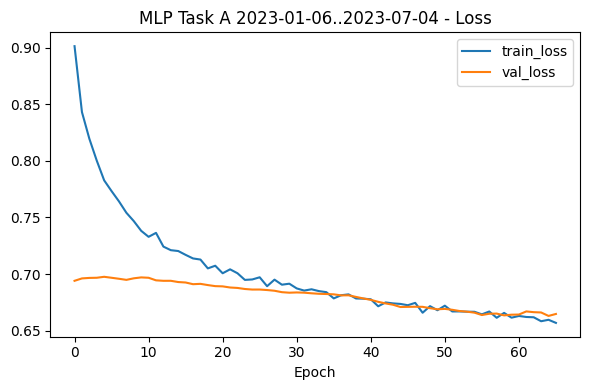

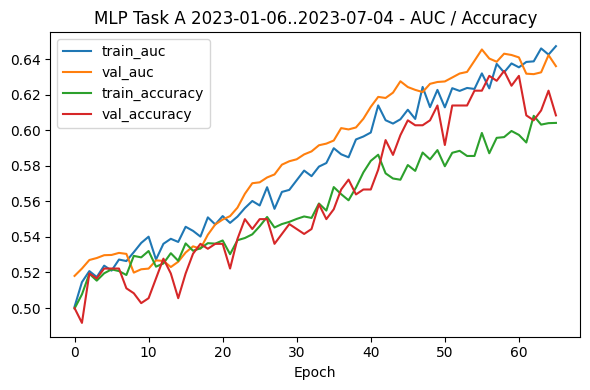

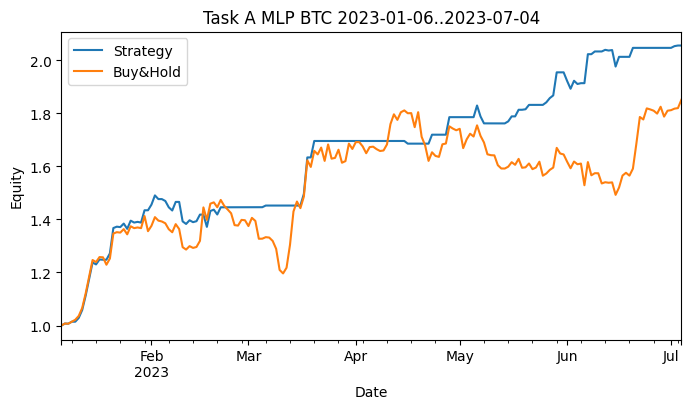

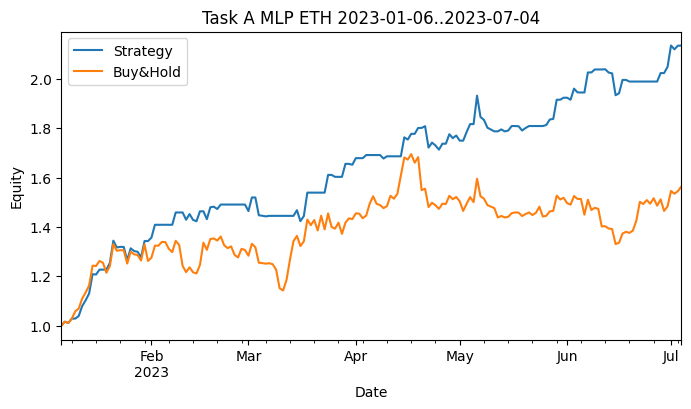

Training LSTM for Task A (next-day direction)...


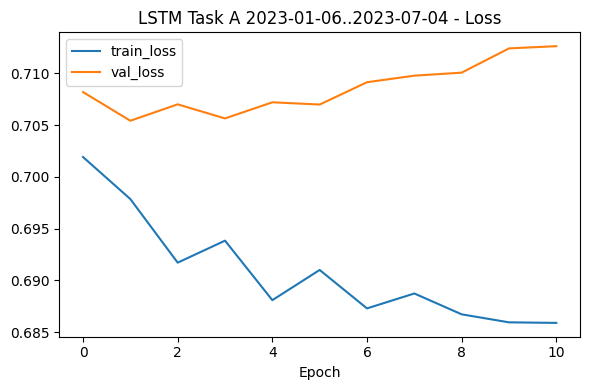

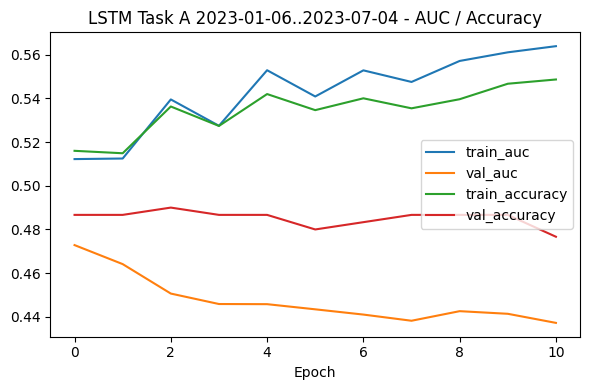

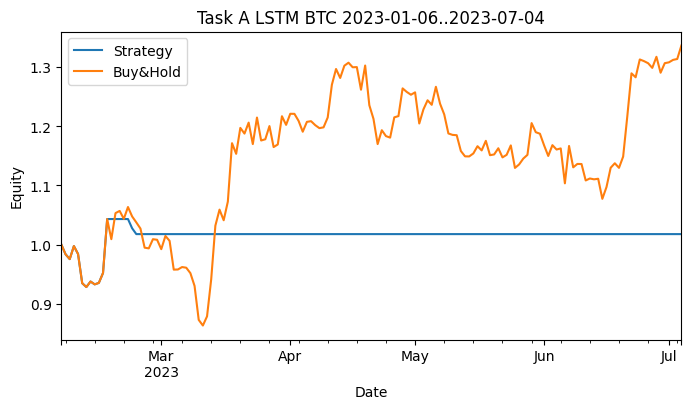

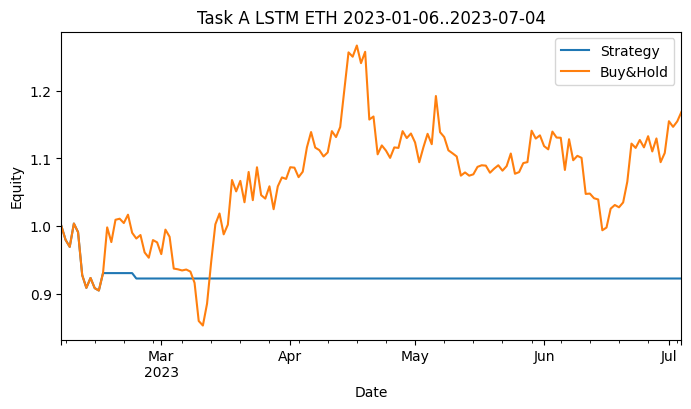

Training MLP for Task B_MIN (y_local_min_7)...


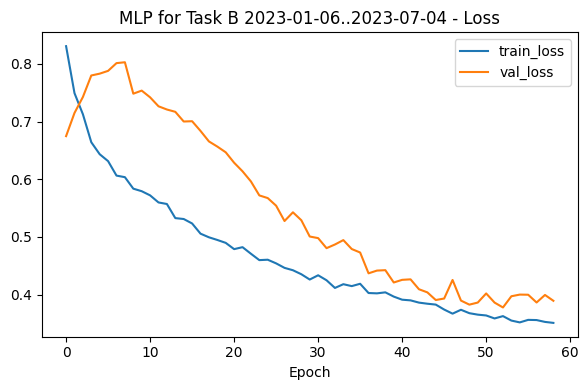

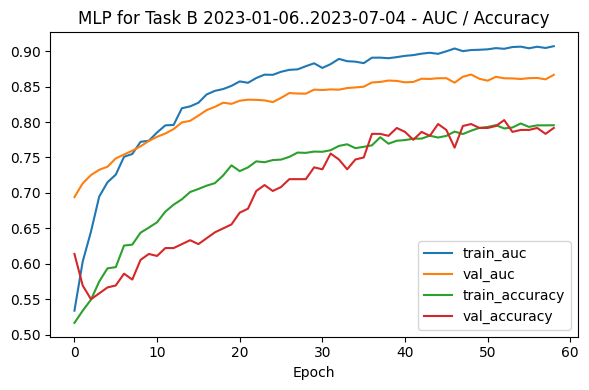

Training MLP for Task B_MAX (y_local_max_7)...


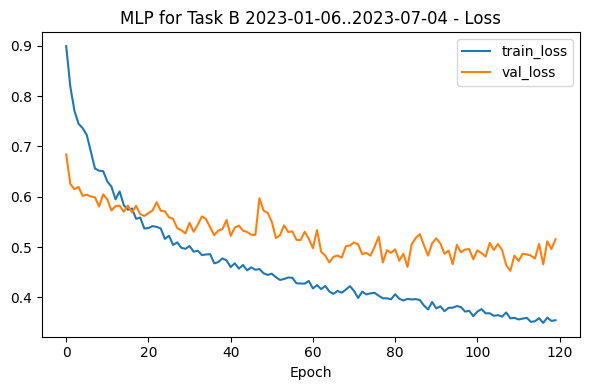

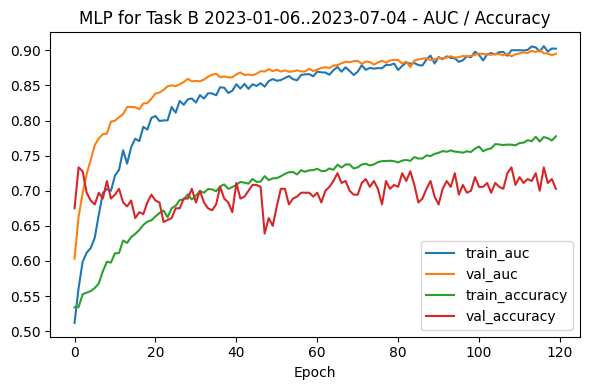

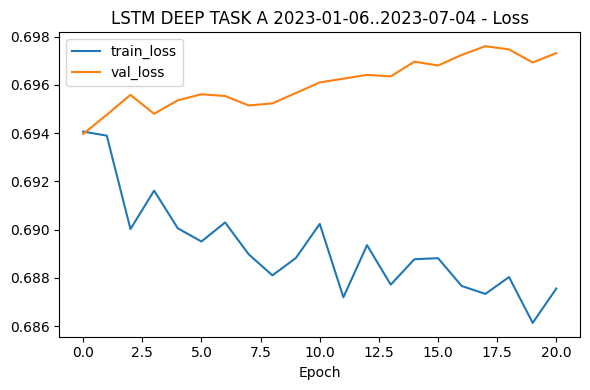

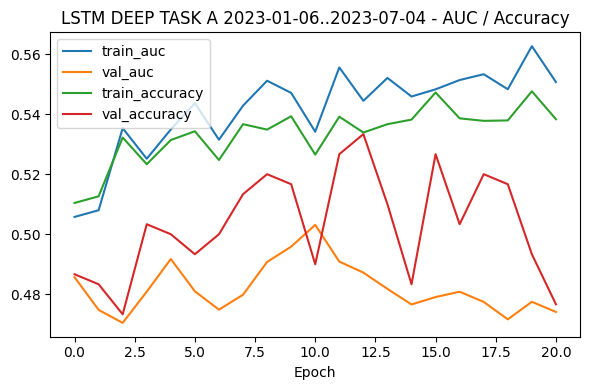

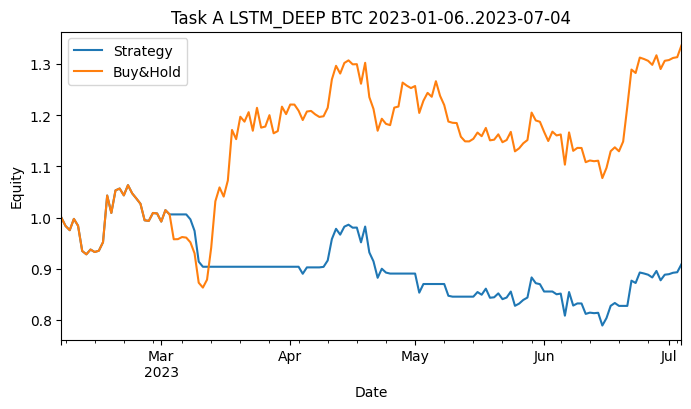

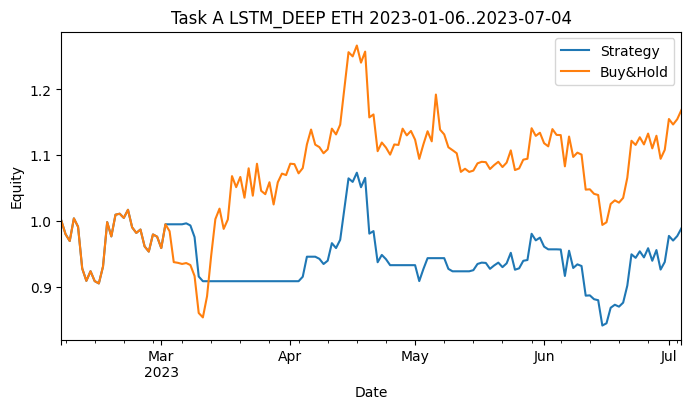

Training CNN-LSTM for Task A (next-day direction)...


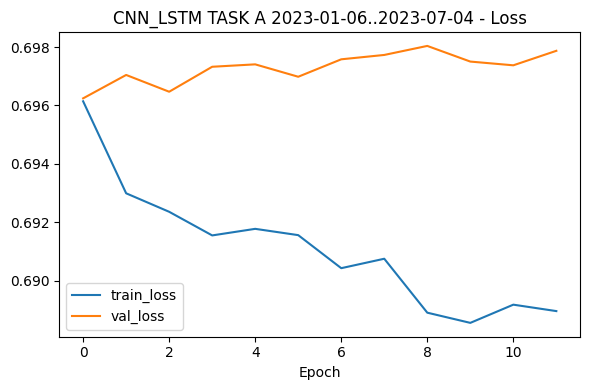

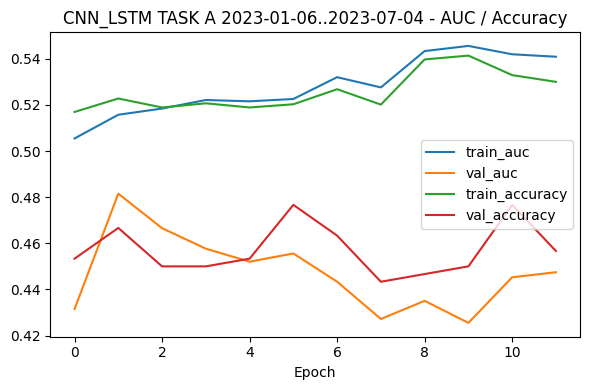

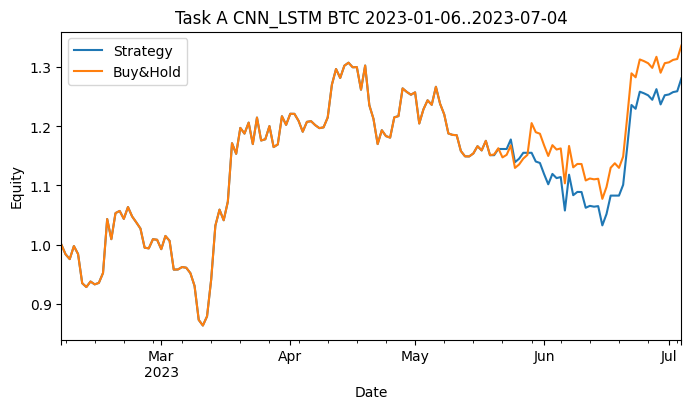

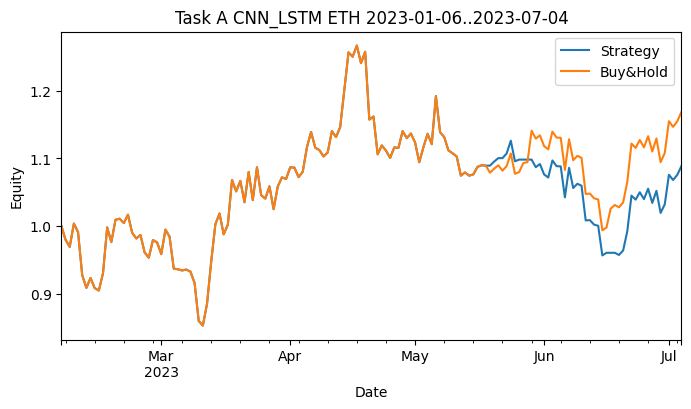


=== Split 2023-07-05..2023-12-31 | Train 7622, Val 360 ===
Training MLP for Task A (next-day direction)...


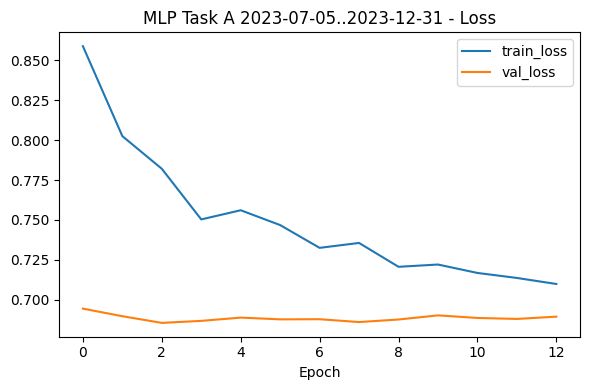

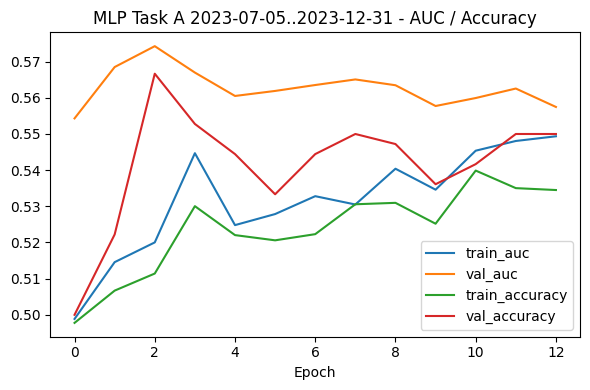

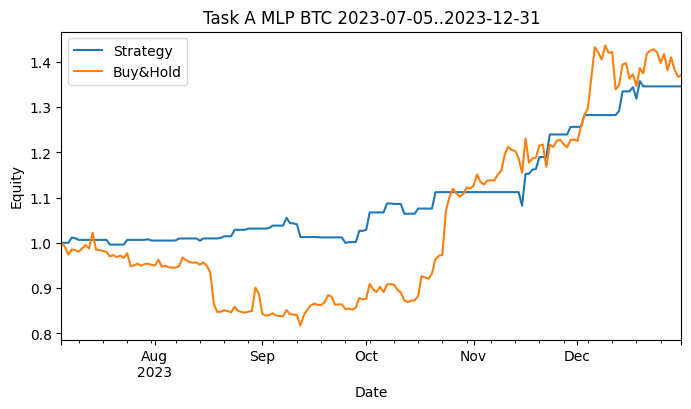

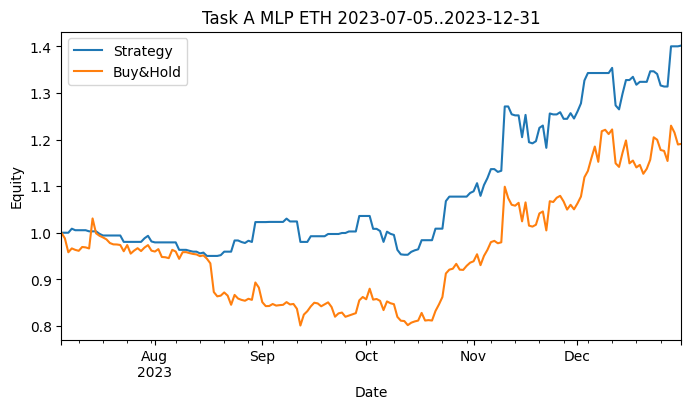

Training LSTM for Task A (next-day direction)...


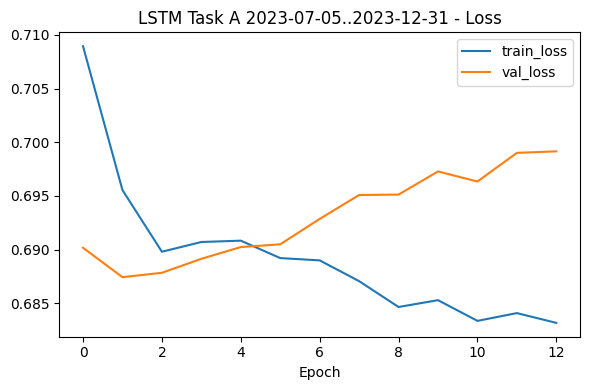

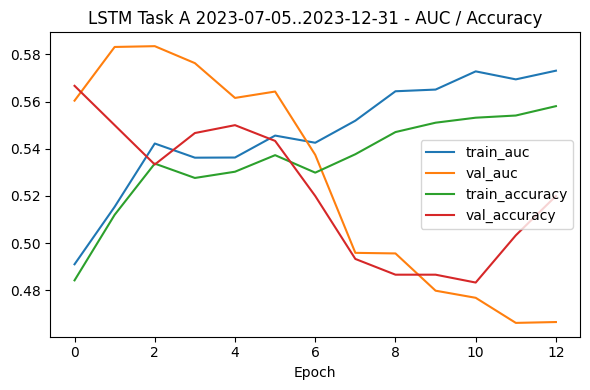

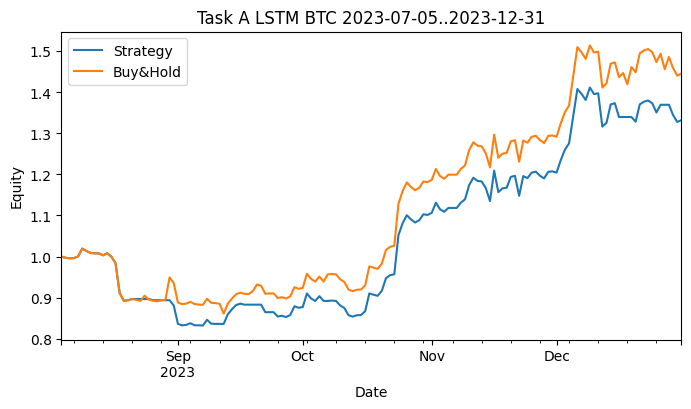

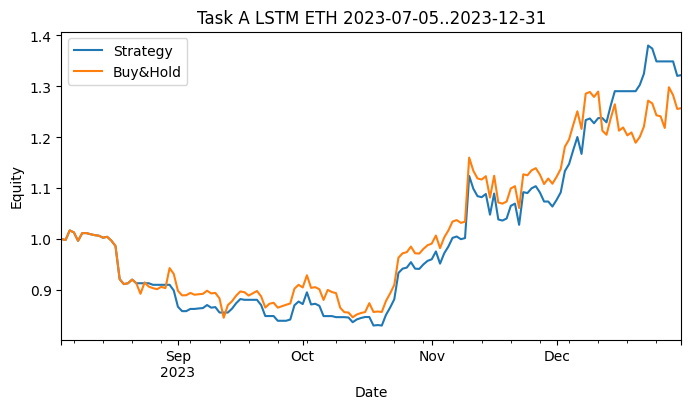

Training MLP for Task B_MIN (y_local_min_7)...


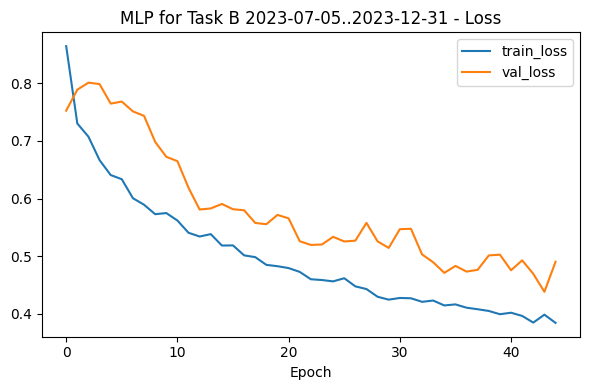

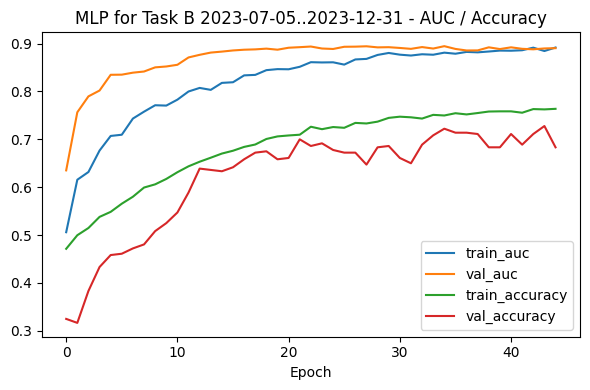

Training MLP for Task B_MAX (y_local_max_7)...


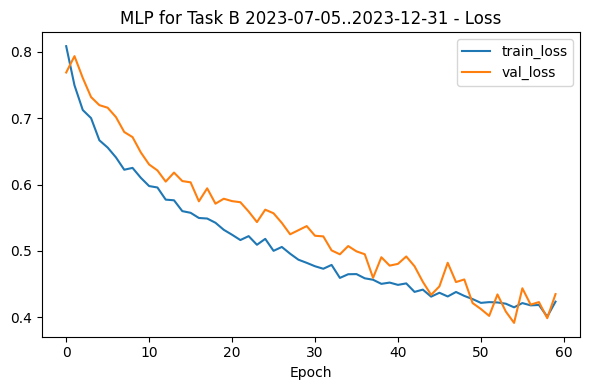

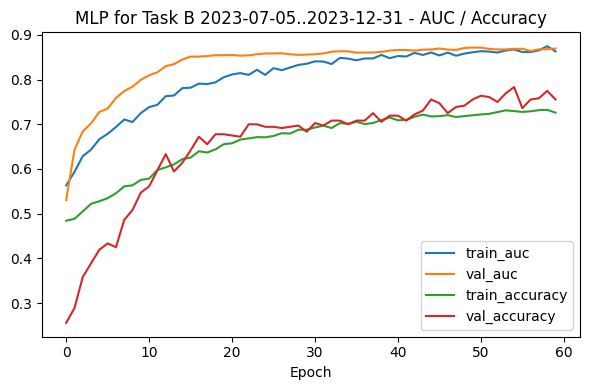

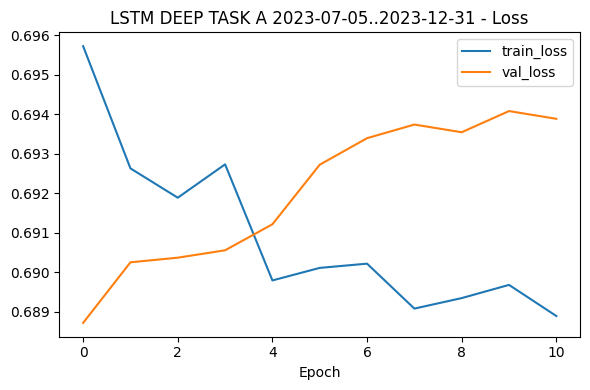

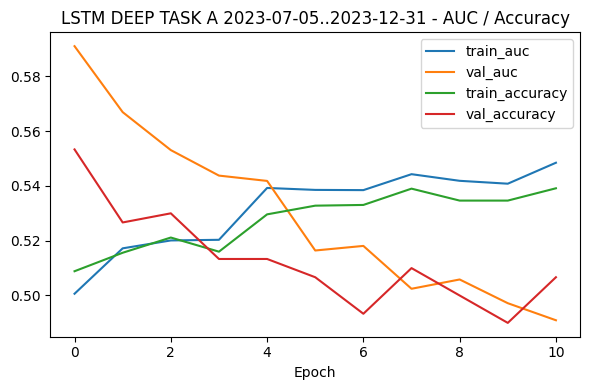

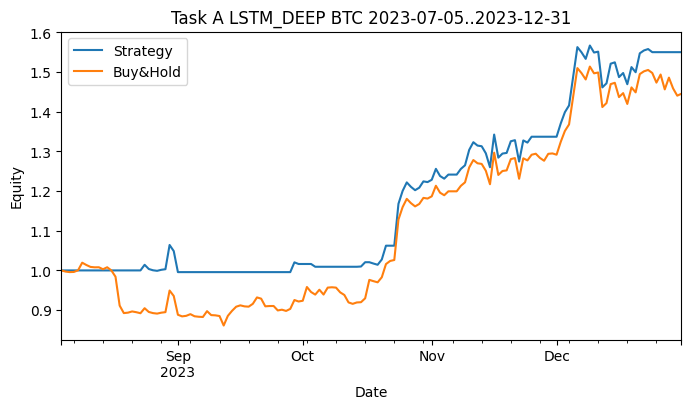

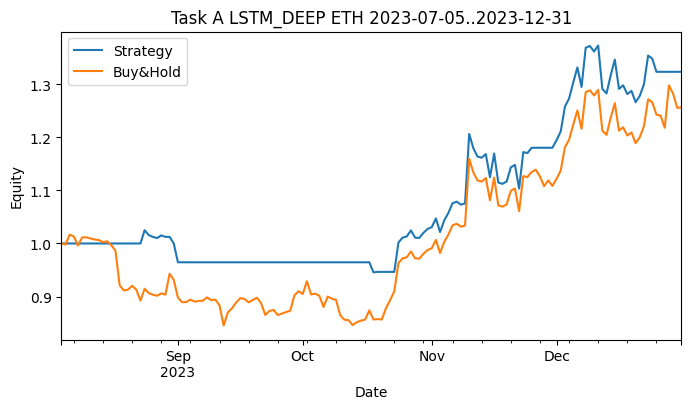

Training CNN-LSTM for Task A (next-day direction)...


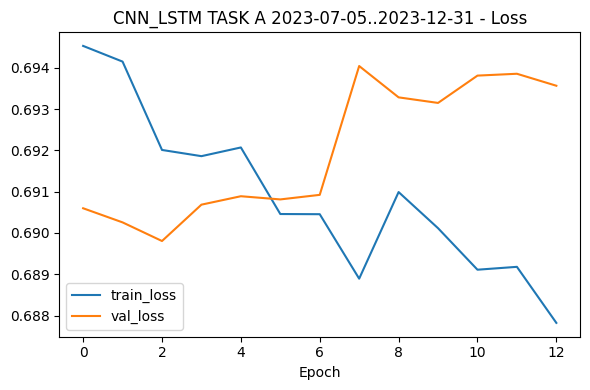

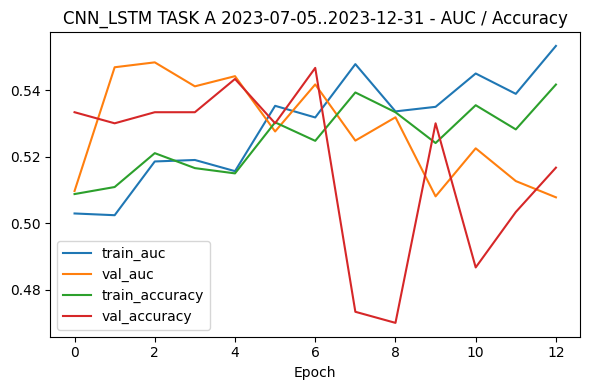

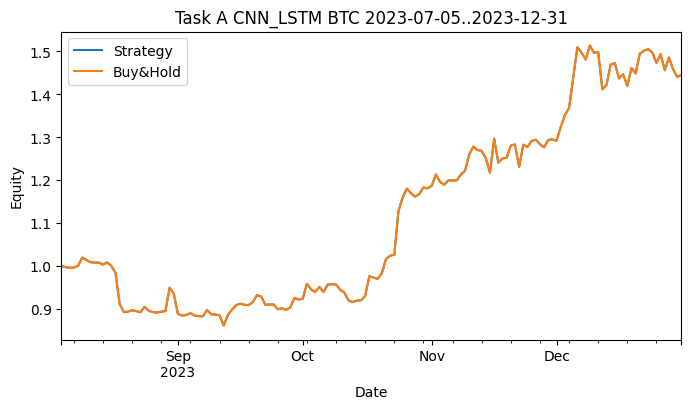

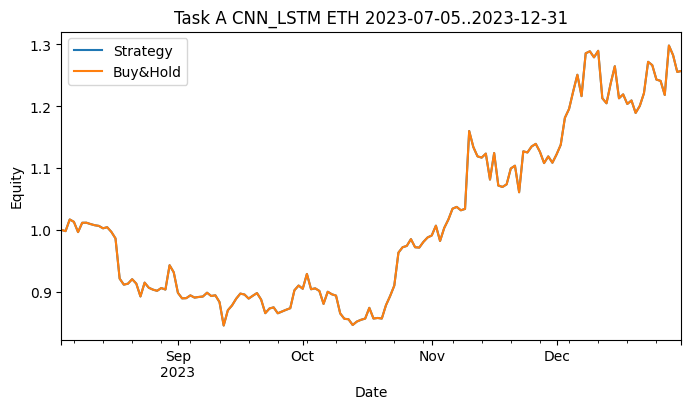


=== Split 2024-01-01..2024-06-28 | Train 7982, Val 360 ===
Training MLP for Task A (next-day direction)...


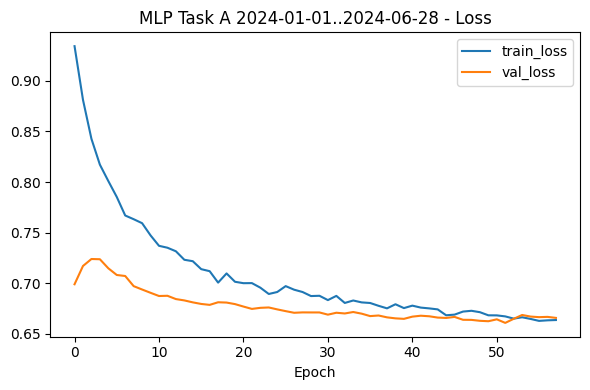

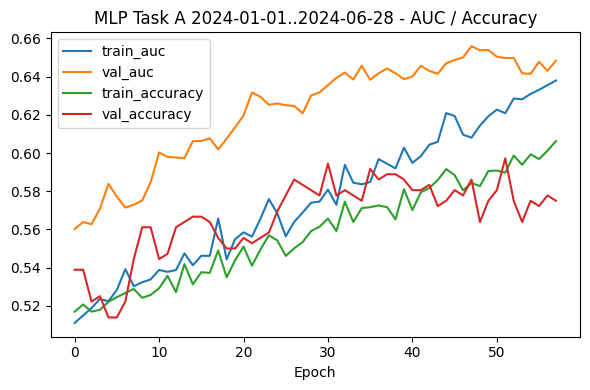

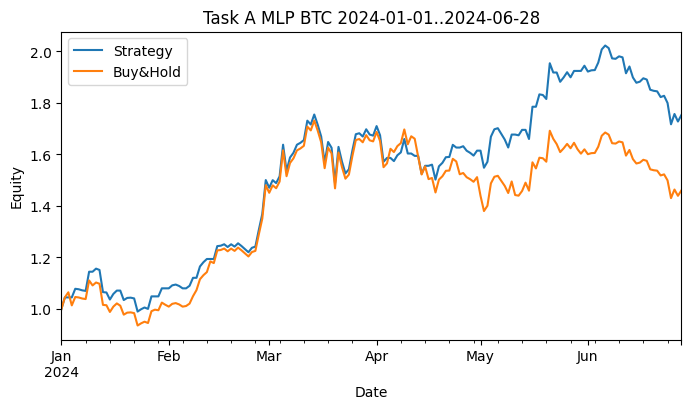

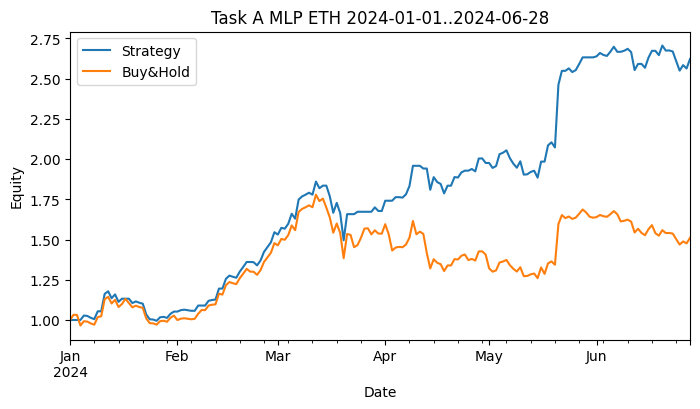

Training LSTM for Task A (next-day direction)...


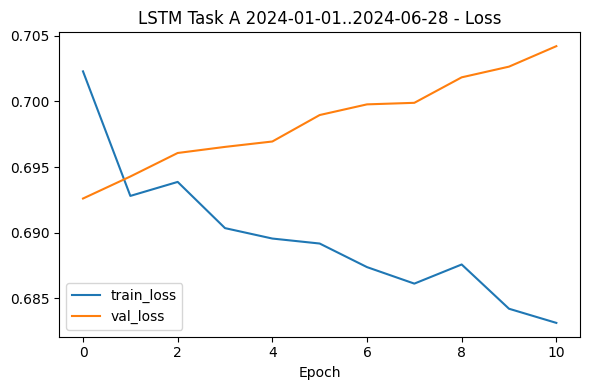

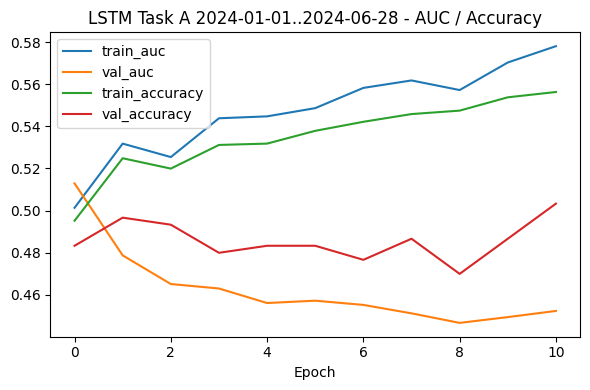

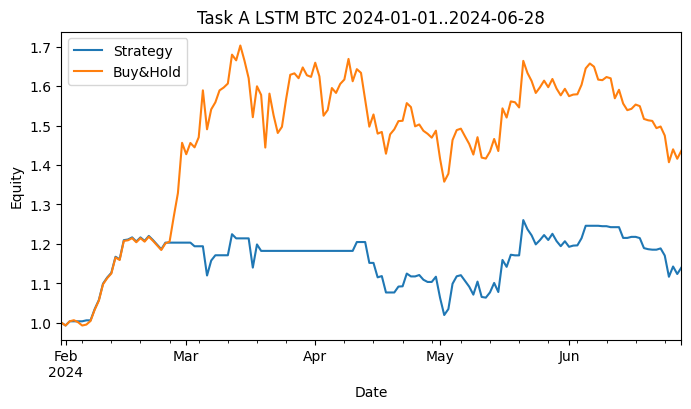

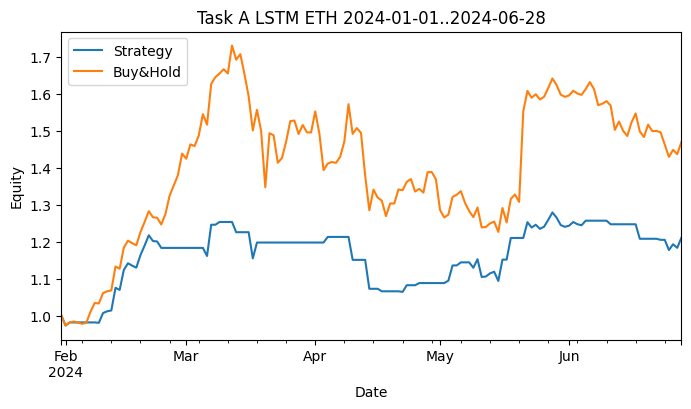

Training MLP for Task B_MIN (y_local_min_7)...


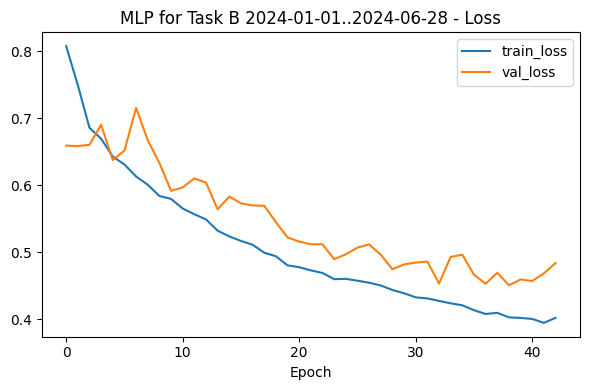

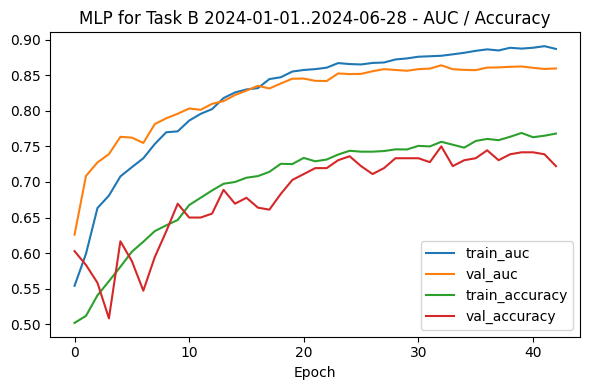

Training MLP for Task B_MAX (y_local_max_7)...


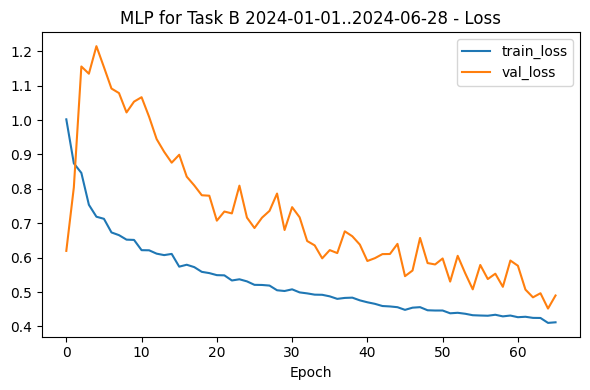

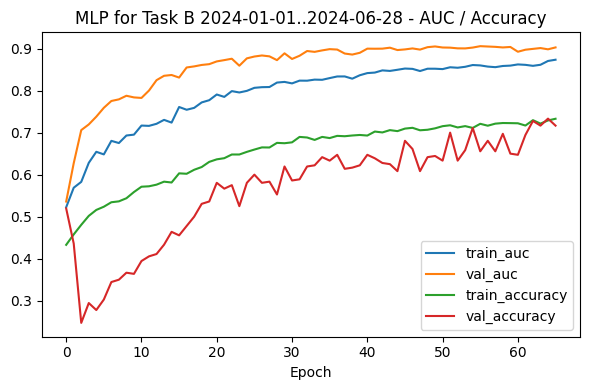

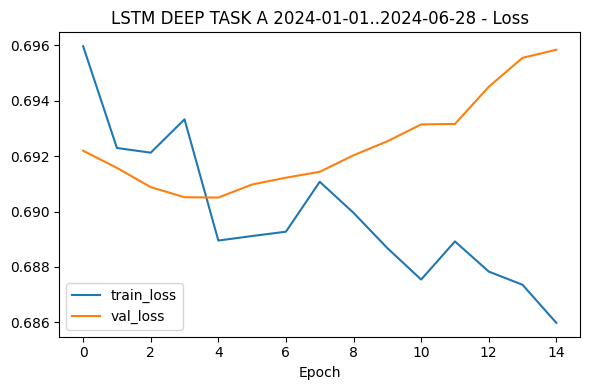

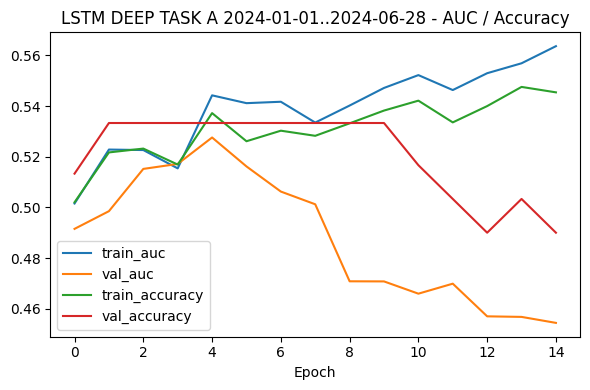

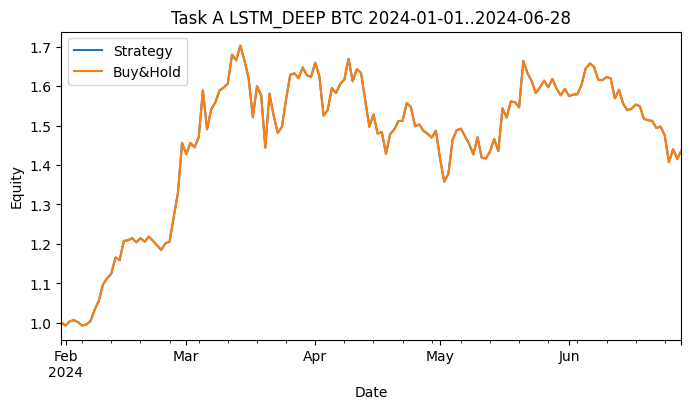

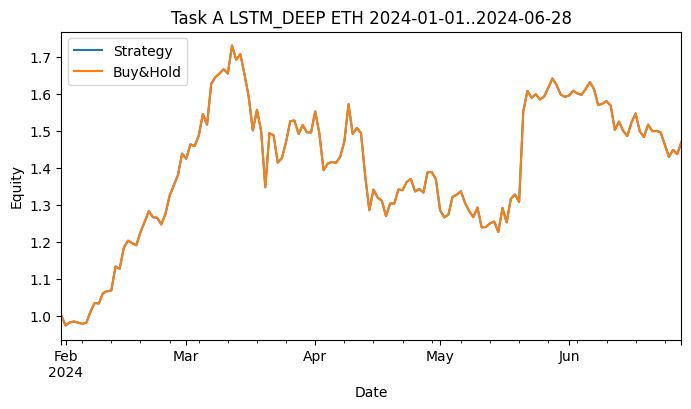

Training CNN-LSTM for Task A (next-day direction)...


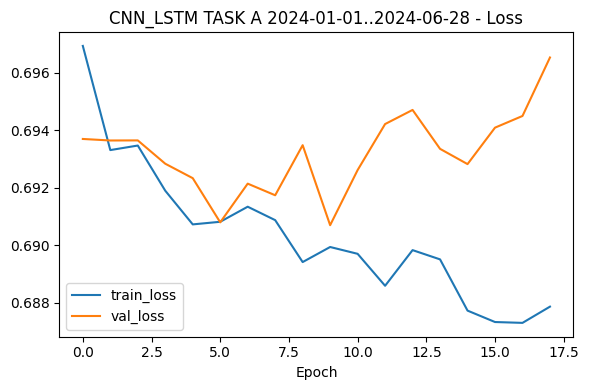

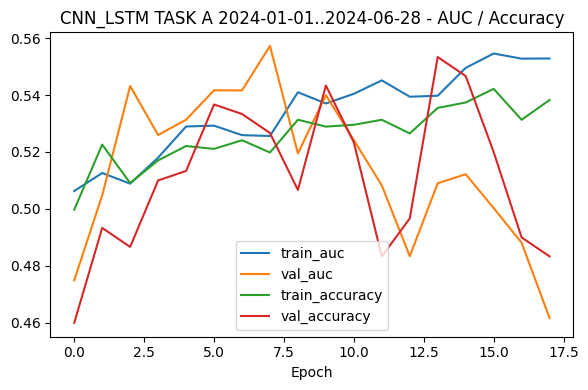

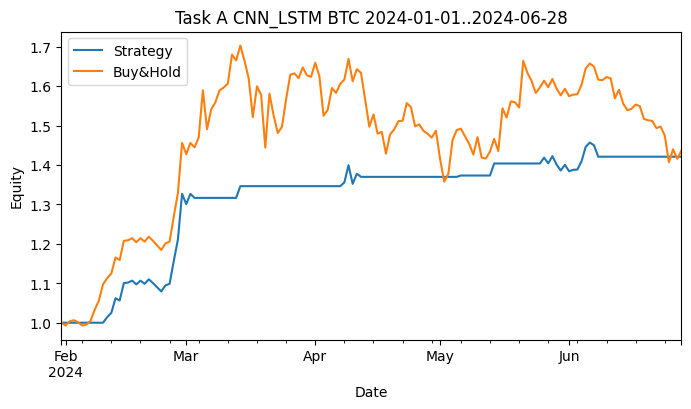

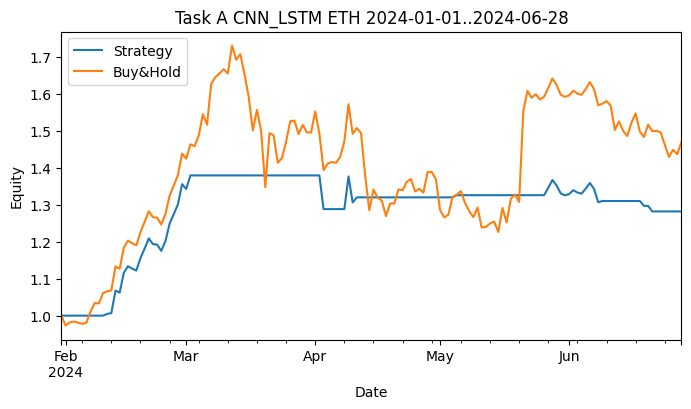


===== RESULTS SUMMARY =====


task      model    coin                    fold       auc       acc  \
0       A        MLP     BTC  2023-01-06..2023-07-04  0.644896  0.622222   
1       A        MLP     ETH  2023-01-06..2023-07-04  0.644896  0.622222   
2       A       LSTM     BTC  2023-01-06..2023-07-04  0.477774  0.486667   
3       A       LSTM     ETH  2023-01-06..2023-07-04  0.466880  0.486667   
4   B_MIN        MLP  POOLED  2023-01-06..2023-07-04  0.867626  0.797222   
5   B_MAX        MLP  POOLED  2023-01-06..2023-07-04  0.900294  0.700000   
6       A  LSTM_DEEP     BTC  2023-01-06..2023-07-04  0.491465  0.466667   
7       A  LSTM_DEEP     ETH  2023-01-06..2023-07-04  0.497507  0.513333   
8       A   CNN_LSTM     BTC  2023-01-06..2023-07-04  0.478485  0.473333   
9       A   CNN_LSTM     ETH  2023-01-06..2023-07-04  0.487536  0.460000   
10      A        MLP     BTC  2023-07-05..2023-12-31  0.572108  0.566667   
11      A        MLP     ETH  2023-07-05..2023-12-31  0.572108  0.566667   
12      A       LSTM     BTC  2023-07-05..2023-12-31  0.583750  0.533333   
13      A       LSTM     ETH  2023-07-05..2023-12-31  0.583929  0.533333   
14  B_MIN        MLP  POOLED  2023-07-05..2023-12-31  0.894904  0.722222   
15  B_MAX        MLP  POOLED  2023-07-05..2023-12-31  0.871608  0.755556   
16      A  LSTM_DEEP     BTC  2023-07-05..2023-12-31  0.589286  0.560000   
17      A  LSTM_DEEP     ETH  2023-07-05..2023-12-31  0.588929  0.546667   
18      A   CNN_LSTM     BTC  2023-07-05..2023-12-31  0.562143  0.533333   
19      A   CNN_LSTM     ETH  2023-07-05..2023-12-31  0.556607  0.533333   
20      A        MLP     BTC  2024-01-01..2024-06-28  0.655338  0.586111   
21      A        MLP     ETH  2024-01-01..2024-06-28  0.655338  0.586111   
22      A       LSTM     BTC  2024-01-01..2024-06-28  0.505438  0.480000   
23      A       LSTM     ETH  2024-01-01..2024-06-28  0.528001  0.486667   
24  B_MIN        MLP  POOLED  2024-01-01..2024-06-28  0.863648  0.750000   
25  B_MAX        MLP  POOLED  2024-01-01..2024-06-28  0.905630  0.655556   
26      A  LSTM_DEEP     BTC  2024-01-01..2024-06-28  0.543769  0.526667   
27      A  LSTM_DEEP     ETH  2024-01-01..2024-06-28  0.508678  0.540000   
28      A   CNN_LSTM     BTC  2024-01-01..2024-06-28  0.546622  0.553333   
29      A   CNN_LSTM     ETH  2024-01-01..2024-06-28  0.551440  0.500000   

      sharpe  equity_end    bh_end  
0   4.110076    2.055667  1.851228  
1   3.806580    2.134470  1.563673  
2   0.269086    1.017839  1.336177  
3  -1.117027    0.922688  1.168392  
4        NaN         NaN       NaN  
5        NaN         NaN       NaN  
6  -0.364964    0.908995  1.336177  
7   0.103160    0.988722  1.168392  
8   1.218754    1.280771  1.336177  
9   0.551901    1.088456  1.168392  
10  2.850123    1.346014  1.371341  
11  1.850428    1.401919  1.190882  
12  1.696883    1.332114  1.445249  
13  1.657052    1.322044  1.257041  
14       NaN         NaN       NaN  
15       NaN         NaN       NaN  
16  2.755544    1.550055  1.445249  
17  1.745805    1.323734  1.257041  
18  2.029463    1.445249  1.445249  
19  1.245719    1.257041  1.257041  
20  2.057179    1.752340  1.459973  
21  3.180924    2.621051  1.509900  
22  0.852679    1.139912  1.436450  
23  1.319379    1.210722  1.470005  
24       NaN         NaN       NaN  
25       NaN         NaN       NaN  
26  1.574382    1.436450  1.436450  
27  1.502626    1.470005  1.470005  
28  3.009055    1.421085  1.436450  
29  2.024380    1.282045  1.470005

In [ ]:
RUN_TASK_A_NEXTDAY = True
RUN_TASK_B_EXTREMA = True
RUN_MLP = True
RUN_LSTM = True
RUN_LSTM_DEEP = True
RUN_CNN_LSTM = True
SEQ_LEN = 60

data = build_dataset_big(CONFIG)
feat_cols, targets = select_feature_columns(data)
data[feat_cols] = data[feat_cols].fillna(method="ffill").fillna(method="bfill")
print("\nNumber of features selected:", len(feat_cols))
splits = walkforward_splits(data.index, n_splits=3, val_days=180)
print("Splits:")

for (tr_end, vs, ve) in splits:
    print(f"  Train <= {tr_end.date()}, Val {vs.date()}..{ve.date()}")

results = []
all_histories_cls = []

for (tr_end, vs, ve) in splits:
    tr, va = subset(data, tr_end, vs, ve)
    if len(tr) < 200 or len(va) < 50:
        print(f"Skipping split {vs.date()}..{ve.date()} (too few rows)")
        continue

    tr_s, va_s, scaler = standardize_train_test(tr, va, feat_cols)
    print(f"\n=== Split {vs.date()}..{ve.date()} | Train {len(tr_s)}, Val {len(va_s)} ===")

    if RUN_TASK_A_NEXTDAY and RUN_MLP:
        print("Training MLP for Task A (next-day direction)...")
        mA, MA = train_eval_mlp(tr_s, va_s, feat_cols, "y_next_up", epochs=120)
        plot_training_history(MA["history"],f"MLP Task A {vs.date()}..{ve.date()}")
        all_histories_cls.append({"task": "A","model": "MLP","fold": f"{vs.date()}..{ve.date()}","hist": MA["history"]})
        p_series = pd.Series(MA["p"], index=va_s.index)

        for coin in ["BTC", "ETH"]:
            idx_coin = va["coin"] == coin
            close = va.loc[idx_coin, "close"]
            proba = p_series.loc[idx_coin]
            if len(close) > 10:
                eq, bh, sh = backtest_long_only(close, proba, tau=0.5)
                results.append(
                    {
                        "task": "A",
                        "model": "MLP",
                        "coin": coin,
                        "fold": f"{vs.date()}..{ve.date()}",
                        "auc": MA["auc"],
                        "acc": MA["acc"],
                        "sharpe": sh,
                        "equity_end": float(eq.iloc[-1]),
                        "bh_end": float(bh.iloc[-1]),
                    }
                )
                plt.figure(figsize=(8, 4))
                eq.plot(label="Strategy")
                bh.plot(label="Buy&Hold")
                plt.legend()
                plt.title(f"Task A MLP {coin} {vs.date()}..{ve.date()}")
                plt.xlabel("Date")
                plt.ylabel("Equity")
                plt.show()

    if RUN_TASK_A_NEXTDAY and RUN_LSTM:
        print("Training LSTM for Task A (next-day direction)...")
        top_vars = tr_s[feat_cols].var().sort_values(ascending=False).head(24).index.tolist()
        seq_len = 60
        mL, ML = train_eval_lstm(tr_s, va_s, top_vars, "y_next_up", epochs=80, seq_len=seq_len)
        plot_training_history(ML["history"],f"LSTM Task A {vs.date()}..{ve.date()}")
        all_histories_cls.append({"task": "A","model": "LSTM","fold": f"{vs.date()}..{ve.date()}","hist": ML["history"]})

        if ML["p"].size > 0:
            coins_for_lstm_predictions = va_s["coin"].iloc[seq_len:]

            for coin in ["BTC", "ETH"]:
                mask_for_coin = coins_for_lstm_predictions == coin
                if mask_for_coin.sum() == 0:
                    continue

                filtered_idx = ML["idx"][mask_for_coin]
                filtered_p = ML["p"][mask_for_coin]
                filtered_y = ML["y"][mask_for_coin]

                close = va["close"].iloc[seq_len:][mask_for_coin]
                proba = pd.Series(filtered_p, index=filtered_idx)

                if len(close) > 10:
                    auc = (
                        roc_auc_score(filtered_y, filtered_p)
                        if len(np.unique(filtered_y)) > 1
                        else np.nan
                    )
                    acc = accuracy_score(filtered_y, (filtered_p > 0.5).astype(int))
                    eq, bh, sh = backtest_long_only(close, proba, tau=0.5)
                    results.append({"task": "A","model": "LSTM","coin": coin,"fold": f"{vs.date()}..{ve.date()}","auc": auc,"acc": acc,"sharpe": sh,"equity_end": float(eq.iloc[-1]),"bh_end": float(bh.iloc[-1])})
                    plt.figure(figsize=(8, 4))
                    eq.plot(label="Strategy")
                    bh.plot(label="Buy&Hold")
                    plt.legend()
                    plt.title(f"Task A LSTM {coin} {vs.date()}..{ve.date()}")
                    plt.xlabel("Date")
                    plt.ylabel("Equity")
                    plt.show()

    if RUN_TASK_B_EXTREMA and RUN_MLP:
        for tgt, TAG in [("y_local_min_7", "MIN"), ("y_local_max_7", "MAX")]:
            posr = tr[tgt].mean()
            cw = (
                None
                if posr in [0, 1, np.nan]
                else {0: 0.5 / (1 - posr + 1e-6), 1: 0.5 / (posr + 1e-6)}
            )
            print(f"Training MLP for Task B_{TAG} ({tgt})...")
            mB, MB = train_eval_mlp(tr_s, va_s, feat_cols, tgt, class_weight=cw, epochs=120)
            plot_training_history(MB["history"],f"MLP for Task B {vs.date()}..{ve.date()}")
            all_histories_cls.append({"task": "B","model": "MLP","fold": f"{vs.date()}..{ve.date()}","hist": ML["history"]})
            results.append({"task": f"B_{TAG}","model": "MLP","coin": "POOLED","fold": f"{vs.date()}..{ve.date()}","auc": MB["auc"],"acc": MB["acc"]})
    if RUN_TASK_A_NEXTDAY and RUN_LSTM_DEEP:
        top_vars = tr_s[feat_cols].var().sort_values(ascending=False).head(32).index.tolist()
        mLd, MLd = train_eval_seq_model(tr_s,va_s,top_vars,target="y_next_up",epochs=80,seq_len=SEQ_LEN,model_builder=make_lstm_deep)
        plot_training_history(MLd["history"],f"LSTM DEEP TASK A {vs.date()}..{ve.date()}")
        all_histories_cls.append({"task": "A","model": "LSTM_DEEP","fold": f"{vs.date()}..{ve.date()}","hist": MLd["history"]})

        if MLd["p"].size > 0:
            coins_for_preds = va_s["coin"].iloc[SEQ_LEN:]

            for coin in ["BTC", "ETH"]:
                mask = coins_for_preds == coin
                if mask.sum() == 0:
                    continue

                filtered_idx = MLd["idx"][mask]
                filtered_p = MLd["p"][mask]
                filtered_y = MLd["y"][mask]

                close = va["close"].iloc[SEQ_LEN:][mask]
                proba = pd.Series(filtered_p, index=filtered_idx)

                if len(close) > 10:
                    auc = (
                        roc_auc_score(filtered_y, filtered_p)
                        if len(np.unique(filtered_y)) > 1
                        else np.nan
                    )
                    acc = accuracy_score(
                        filtered_y, (filtered_p > 0.5).astype(int)
                    )

                    eq, bh, sh = backtest_long_only(close, proba, tau=0.5)
                    results.append({"task": "A","model": "LSTM_DEEP","coin": coin,"fold": f"{vs.date()}..{ve.date()}","auc": auc,"acc": acc,"sharpe": sh,"equity_end": float(eq.iloc[-1]),"bh_end": float(bh.iloc[-1])})

                    plt.figure(figsize=(8, 4))
                    eq.plot(label="Strategy")
                    bh.plot(label="Buy&Hold")
                    plt.legend()
                    plt.title(f"Task A LSTM_DEEP {coin} {vs.date()}..{ve.date()}")
                    plt.xlabel("Date")
                    plt.ylabel("Equity")
                    plt.show()

    if RUN_TASK_A_NEXTDAY and RUN_CNN_LSTM:
        print("Training CNN-LSTM for Task A (next-day direction)...")
        top_vars = tr_s[feat_cols].var().sort_values(ascending=False).head(32).index.tolist()
        mCL, MCL = train_eval_seq_model(tr_s,va_s,top_vars,target="y_next_up",epochs=25,seq_len=SEQ_LEN,model_builder=make_cnn_lstm)
        plot_training_history(MCL["history"],f"CNN_LSTM TASK A {vs.date()}..{ve.date()}")
        all_histories_cls.append({"task": "A","model": "CNN_LSTM","fold": f"{vs.date()}..{ve.date()}","hist": MCL["history"]})

        if MCL["p"].size > 0:
            coins_for_preds = va_s["coin"].iloc[SEQ_LEN:]

            for coin in ["BTC", "ETH"]:
                mask = coins_for_preds == coin
                if mask.sum() == 0:
                    continue

                filtered_idx = MCL["idx"][mask]
                filtered_p = MCL["p"][mask]
                filtered_y = MCL["y"][mask]

                close = va["close"].iloc[SEQ_LEN:][mask]
                proba = pd.Series(filtered_p, index=filtered_idx)

                if len(close) > 10:
                    auc = (
                        roc_auc_score(filtered_y, filtered_p)
                        if len(np.unique(filtered_y)) > 1
                        else np.nan
                    )
                    acc = accuracy_score(
                        filtered_y, (filtered_p > 0.5).astype(int)
                    )

                    eq, bh, sh = backtest_long_only(close, proba, tau=0.5)
                    results.append({"task": "A","model": "CNN_LSTM","coin": coin,"fold": f"{vs.date()}..{ve.date()}","auc": auc,"acc": acc,"sharpe": sh,"equity_end": float(eq.iloc[-1]),"bh_end": float(bh.iloc[-1])})

                    plt.figure(figsize=(8, 4))
                    eq.plot(label="Strategy")
                    bh.plot(label="Buy&Hold")
                    plt.legend()
                    plt.title(f"Task A CNN_LSTM {coin} {vs.date()}..{ve.date()}")
                    plt.xlabel("Date")
                    plt.ylabel("Equity")
                    plt.show()

res = pd.DataFrame(results) if len(results) else pd.DataFrame()
print("\n===== RESULTS SUMMARY =====")
if res.empty:
    print("No results yet.")
else:
    display(res)

## Regression

BTC price head:
               open    high     low   close  volume  market_cap
date                                                          
2010-07-18  0.0500  0.0500  0.0500  0.0500     0.0         0.0
2010-07-19  0.0858  0.0858  0.0858  0.0858     0.0         0.0
2010-07-20  0.0808  0.0808  0.0808  0.0808     0.0         0.0

ETH price head:
                 open      high       low     close         volume  \
date                                                                
2015-08-09  2.772120  2.798810  0.714725  0.714876  314143.614583   
2015-08-10  0.753325  0.879810  0.629191  0.729347  699826.371528   
2015-08-11  0.701897  0.729854  0.636546  0.707703  457747.909722   

              market_cap  
date                      
2015-08-09  1.039569e+08  
2015-08-10  4.156260e+07  
2015-08-11  4.182758e+07  

News daily head:
   coin       date  news_count  title_len_mean  sent_mean  sent_std
0  BTC 2013-04-08           1            33.0        0.0       NaN
1  BTC 2013-04-1

/tmp/ipython-input-2890093288.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[feat_cols] = data[feat_cols].fillna(method="ffill").fillna(method="bfill")



--- Regression split 2023-01-06..2023-07-04 | Train 7262, Val 360 ---


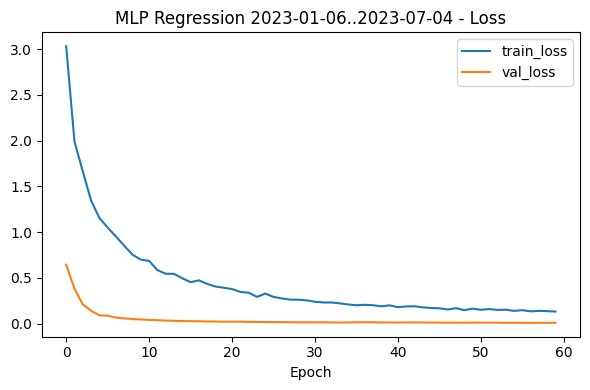

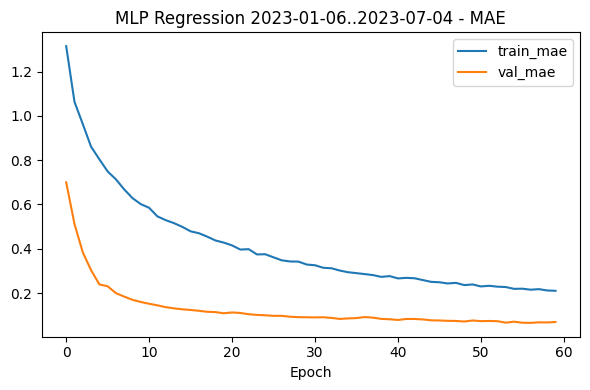

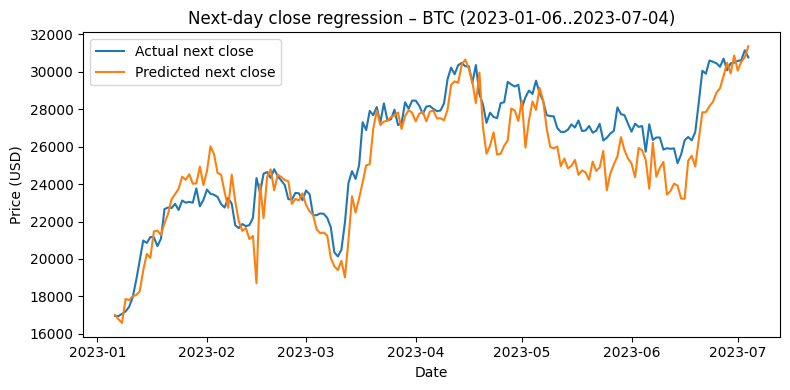

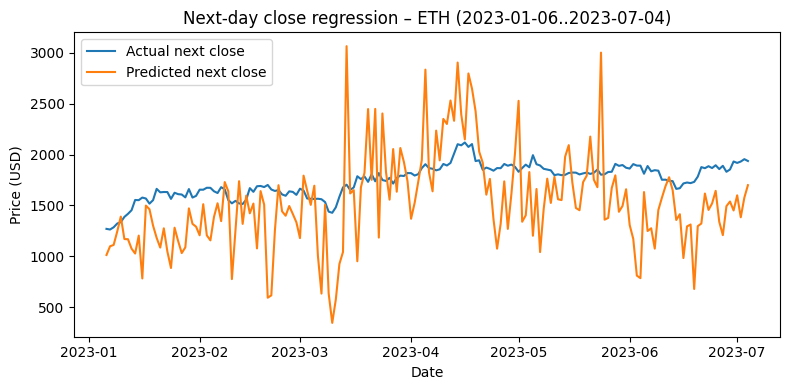


--- Regression split 2023-07-05..2023-12-31 | Train 7622, Val 360 ---


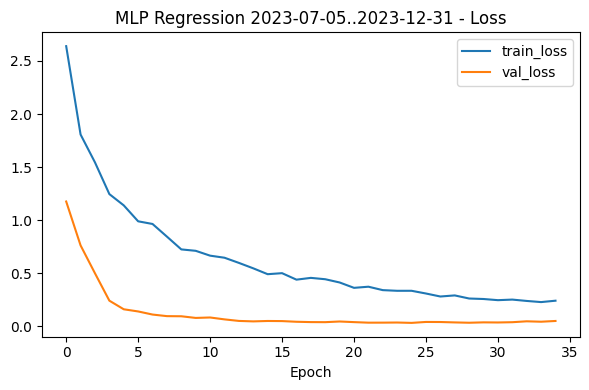

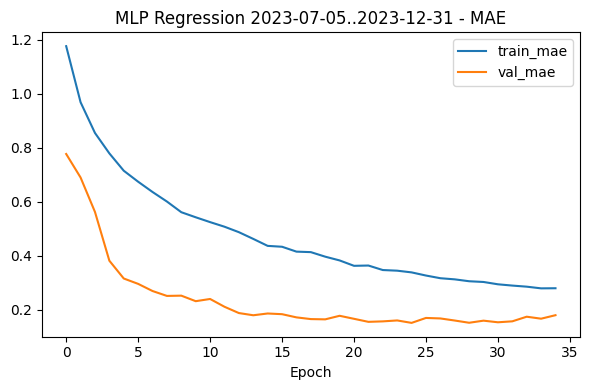

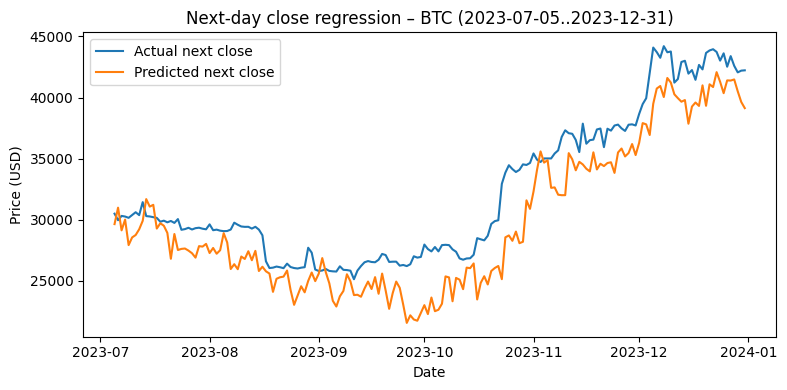

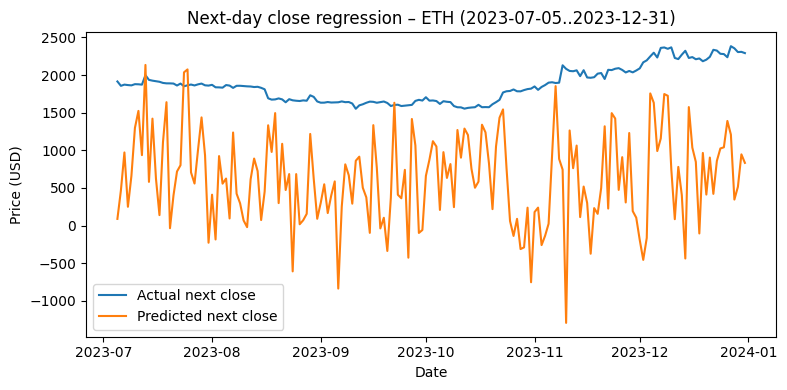


--- Regression split 2024-01-01..2024-06-28 | Train 7982, Val 358 ---


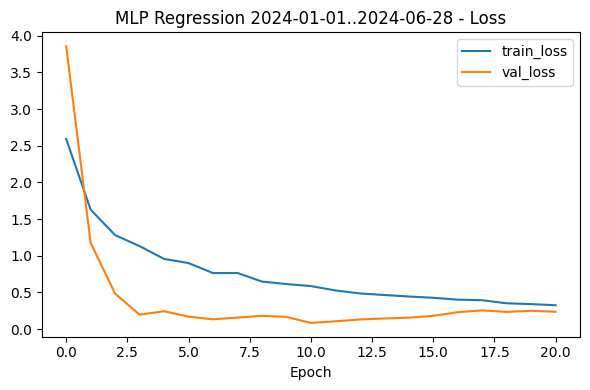

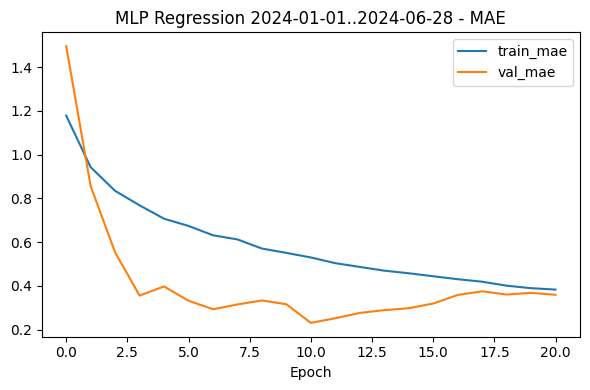

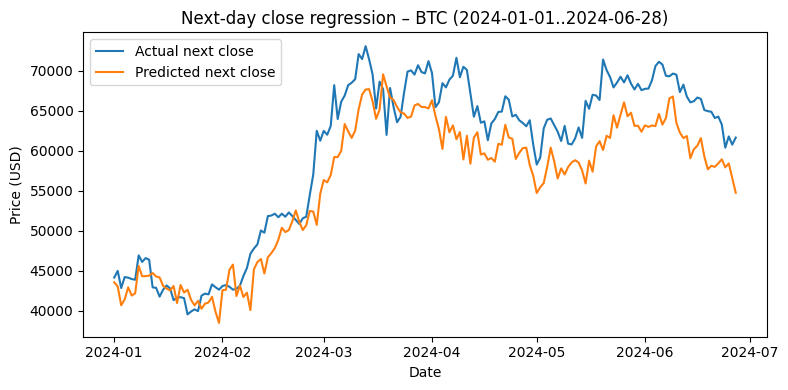

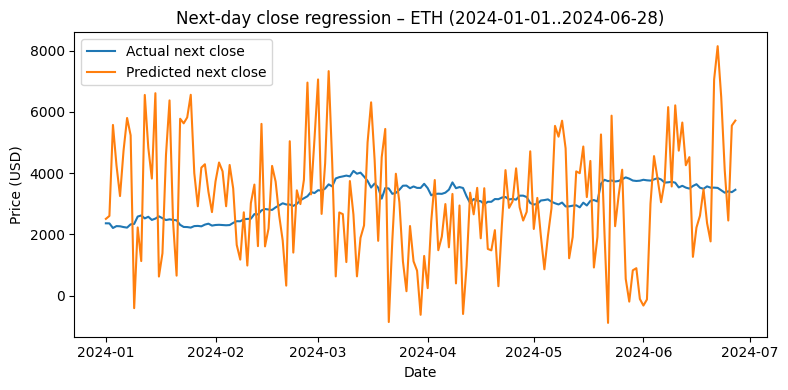


===== REGRESSION RESULTS SUMMARY =====


fold          mae         rmse
0  2023-01-06..2023-07-04   787.807739  1117.053322
1  2023-07-05..2023-12-31  1842.029907  2229.272079
2  2024-01-01..2024-06-28  2904.174316  3681.169923

In [ ]:
RUN_REGRESSION = True

data = build_dataset_big(CONFIG)
feat_cols, targets = select_feature_columns(data)
data[feat_cols] = data[feat_cols].fillna(method="ffill").fillna(method="bfill")

print("\nNumber of features selected:", len(feat_cols))
splits = walkforward_splits(data.index, n_splits=3, val_days=180)
print("Splits:")
for (tr_end, vs, ve) in splits: print(f"  Train <= {tr_end.date()}, Val {vs.date()}..{ve.date()}")

all_histories_reg = []

if RUN_REGRESSION:
    data_reg = data.copy()
    data_reg["next_close"] = (data_reg.groupby("coin")["close"].shift(-1))
    data_reg = data_reg.dropna(subset=["next_close"]).copy()
    reg_results = []
    print("\n=== REGRESSION: next-day close (same walk-forward splits) ===")

    for (tr_end, vs, ve) in splits:
        tr, va = subset(data_reg, tr_end, vs, ve)
        if len(tr) < 200 or len(va) < 30:
            print(f"Skipping regression split {vs.date()}..{ve.date()} (too few rows)")
            continue

        tr_s, va_s, _ = standardize_train_test(tr, va, feat_cols)

        print(f"\n--- Regression split {vs.date()}..{ve.date()} | Train {len(tr_s)}, Val {len(va_s)} ---")

        mR, MR = train_eval_mlp_reg(tr_s, va_s, feat_cols, target_col="next_close", epochs=60)
        plot_training_history(MR["history"],f"MLP Regression {vs.date()}..{ve.date()}")
        all_histories_reg.append({"coin": coin,"fold": f"{vs.date()}..{ve.date()}","hist": MR["history"]})
        reg_results.append({"fold": f"{vs.date()}..{ve.date()}","mae": MR["mae"],"rmse": MR["rmse"]})
        actual_series = pd.Series(MR["y"], index=va_s.index)
        preds_series  = pd.Series(MR["p"], index=va_s.index)

        for coin in ["BTC", "ETH"]:
            mask = va["coin"] == coin
            if mask.sum() < 5:
                continue

            dates  = va.index[mask]
            actual = actual_series.loc[mask]
            pred   = preds_series.loc[mask]

            plt.figure(figsize=(8, 4))
            plt.plot(dates, actual, label="Actual next close")
            plt.plot(dates, pred, label="Predicted next close")
            plt.title(f"Next-day close regression – {coin} ({vs.date()}..{ve.date()})")
            plt.xlabel("Date")
            plt.ylabel("Price (USD)")
            plt.legend()
            plt.tight_layout()
            plt.show()

    reg_res_df = pd.DataFrame(reg_results) if len(reg_results) else pd.DataFrame()
    print("\n===== REGRESSION RESULTS SUMMARY =====")
    if reg_res_df.empty:
        print("No regression results.")
    else:
        display(reg_res_df)


# MODIFIED REGRESSION

BTC price head:
               open    high     low   close  volume  market_cap
date                                                          
2010-07-18  0.0500  0.0500  0.0500  0.0500     0.0         0.0
2010-07-19  0.0858  0.0858  0.0858  0.0858     0.0         0.0
2010-07-20  0.0808  0.0808  0.0808  0.0808     0.0         0.0

ETH price head:
                 open      high       low     close         volume  \
date                                                                
2015-08-09  2.772120  2.798810  0.714725  0.714876  314143.614583   
2015-08-10  0.753325  0.879810  0.629191  0.729347  699826.371528   
2015-08-11  0.701897  0.729854  0.636546  0.707703  457747.909722   

              market_cap  
date                      
2015-08-09  1.039569e+08  
2015-08-10  4.156260e+07  
2015-08-11  4.182758e+07  

News daily head:
   coin       date  news_count  title_len_mean  sent_mean  sent_std
0  BTC 2013-04-08           1            33.0        0.0       NaN
1  BTC 2013-04-1

/tmp/ipython-input-3448795184.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[feat_cols] = data[feat_cols].fillna(method="ffill").fillna(method="bfill")



--- Regression split 2023-01-06..2023-07-04 ---


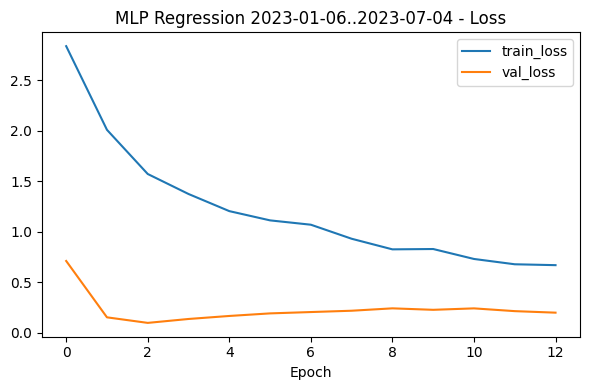

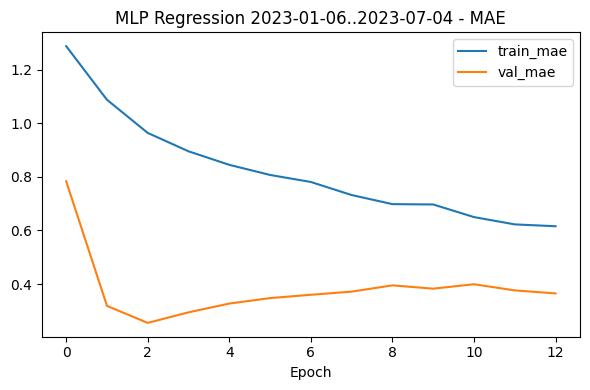

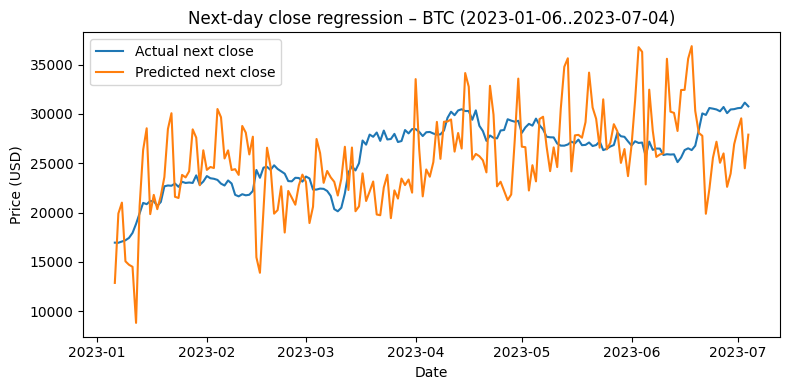

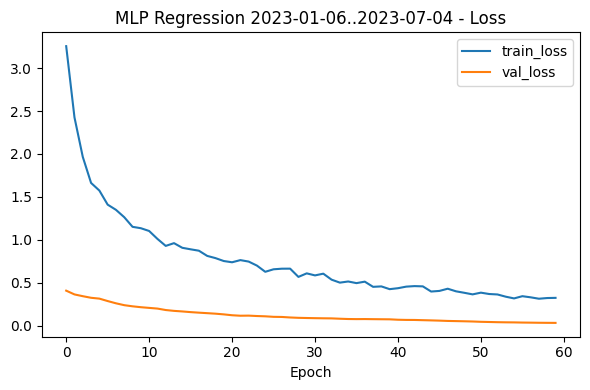

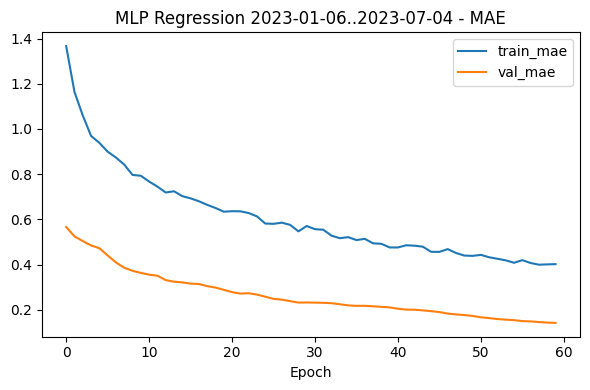

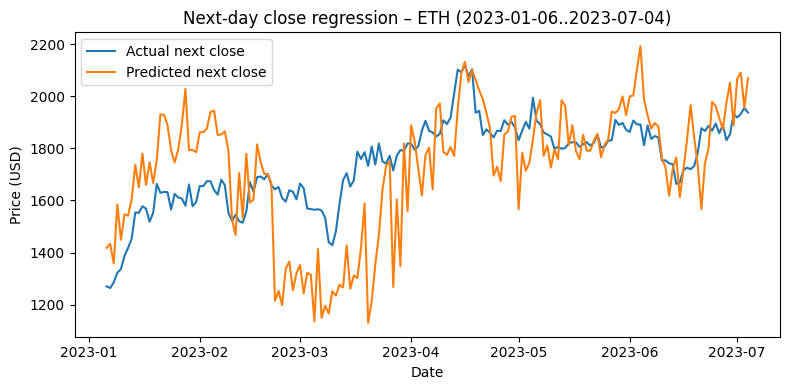


--- Regression split 2023-07-05..2023-12-31 ---


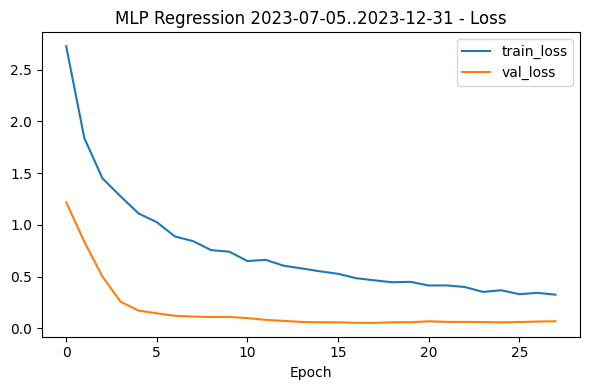

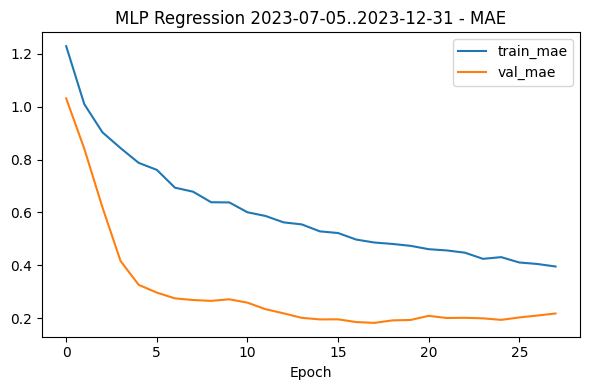

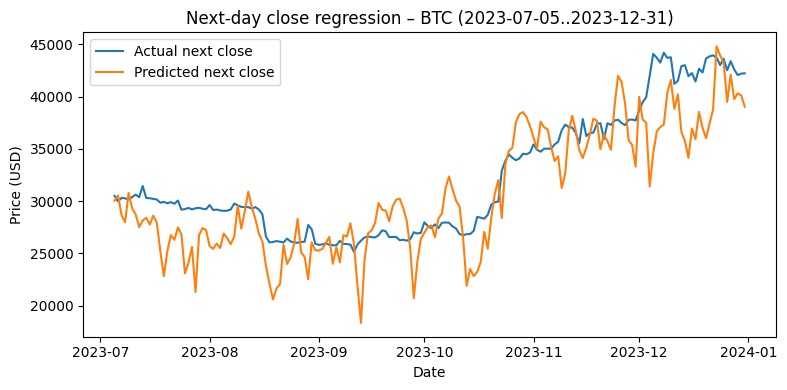

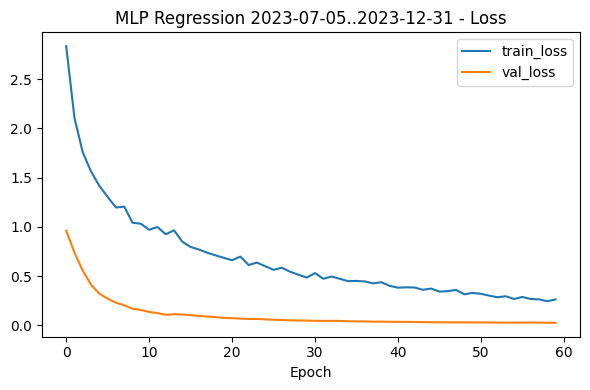

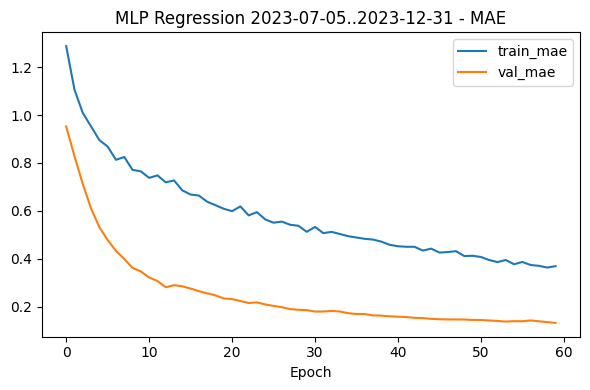

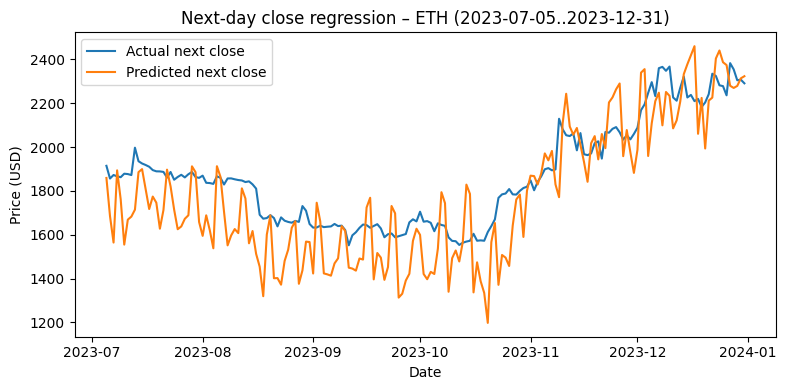


--- Regression split 2024-01-01..2024-06-28 ---


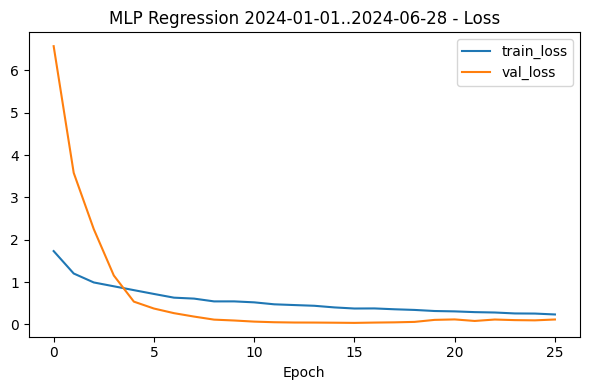

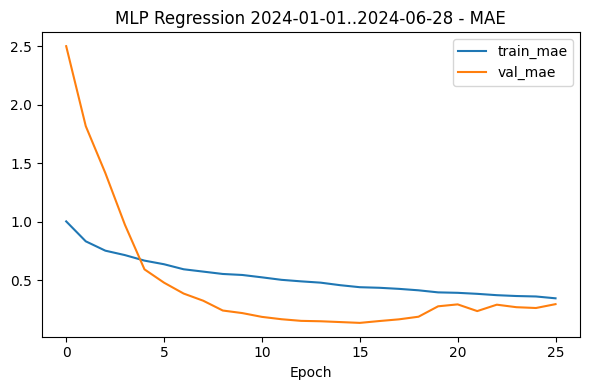

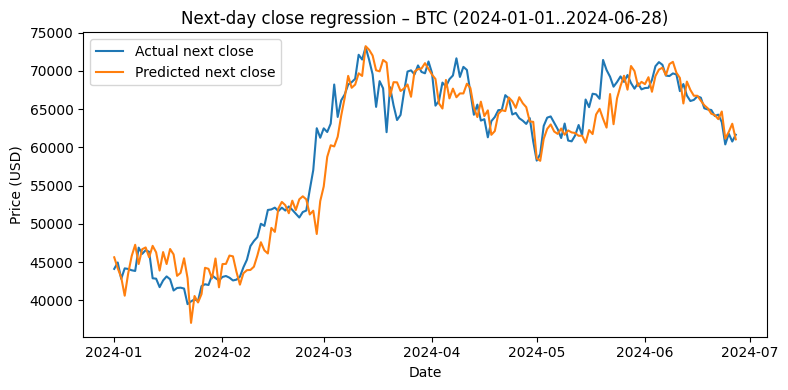

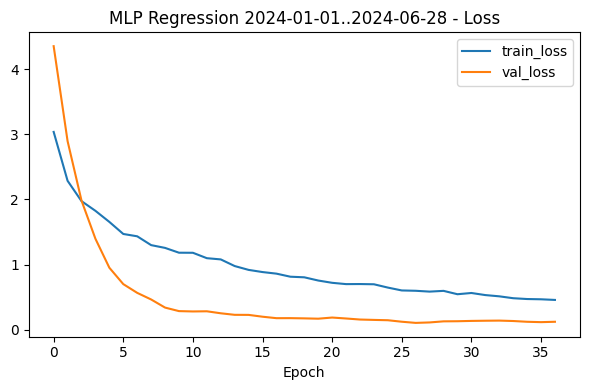

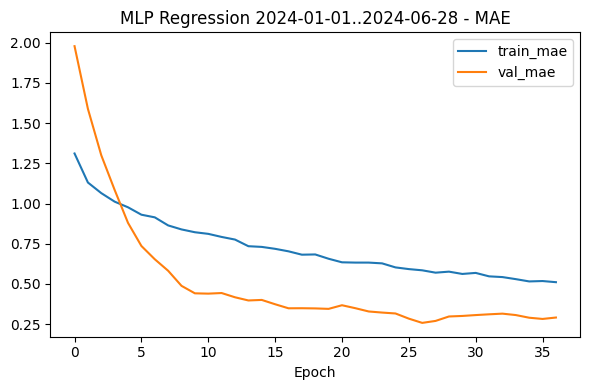

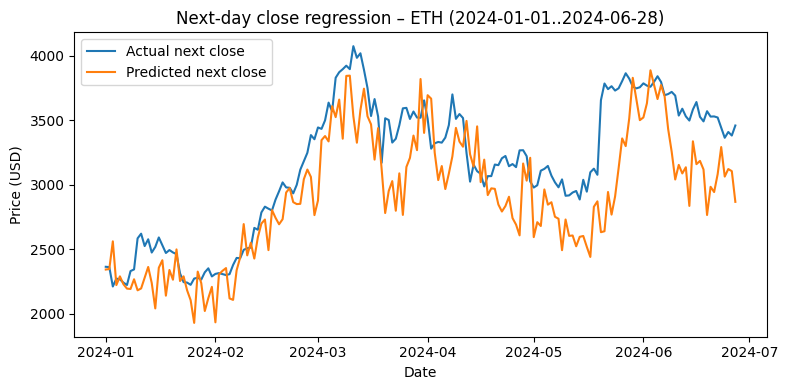


===== REGRESSION RESULTS SUMMARY =====


coin                    fold          mae         rmse
0  BTC  2023-01-06..2023-07-04  3693.157715  4497.223810
1  ETH  2023-01-06..2023-07-04   157.296707   202.967006
2  BTC  2023-07-05..2023-12-31  2663.279053  3356.958147
3  ETH  2023-07-05..2023-12-31   144.334122   173.368826
4  BTC  2024-01-01..2024-06-28  2045.326416  2809.220532
5  ETH  2024-01-01..2024-06-28   281.657715   355.625231

In [ ]:
RUN_REGRESSION_MODIFIED = True

data = build_dataset_big(CONFIG)
feat_cols, targets = select_feature_columns(data)
data[feat_cols] = data[feat_cols].fillna(method="ffill").fillna(method="bfill")
print("\nNumber of features selected:", len(feat_cols))
splits = walkforward_splits(data.index, n_splits=3, val_days=180)
print("Splits:")
for (tr_end, vs, ve) in splits: print(f"  Train <= {tr_end.date()}, Val {vs.date()}..{ve.date()}")

all_histories_reg_modified = []

if RUN_REGRESSION_MODIFIED:
    print("=== REGRESSION: next-day close (per-coin MLP, same splits) ===")
    data_reg = data.copy()
    data_reg["next_close"] = (data_reg.groupby("coin")["close"].shift(-1))
    data_reg = data_reg.dropna(subset=["next_close"]).copy()
    reg_results_modified = []

    for (tr_end, vs, ve) in splits:
        print(f"\n--- Regression split {vs.date()}..{ve.date()} ---")
        tr_all, va_all = subset(data_reg, tr_end, vs, ve)

        for coin in ["BTC", "ETH"]:
            tr = tr_all[tr_all["coin"] == coin].copy()
            va = va_all[va_all["coin"] == coin].copy()

            if len(tr) < 200 or len(va) < 30:
                print(f"  [{coin}] skipping (train {len(tr)}, val {len(va)})")
                continue

            tr_s, va_s, _ = standardize_train_test(tr, va, feat_cols)
            mR, MR = train_eval_mlp_reg(tr_s,va_s,feat_cols,target_col="next_close",epochs=60)
            plot_training_history(MR["history"],f"MLP Regression {vs.date()}..{ve.date()}")
            all_histories_reg_modified.append({"coin": coin,"fold": f"{vs.date()}..{ve.date()}","hist": MR["history"]})
            reg_results_modified.append({"coin": coin,"fold": f"{vs.date()}..{ve.date()}","mae": MR["mae"],"rmse": MR["rmse"]})

            dates  = va.index
            actual = pd.Series(MR["y"], index=dates)
            pred   = pd.Series(MR["p"], index=dates)
            plt.figure(figsize=(8, 4))
            plt.plot(dates, actual, label="Actual next close")
            plt.plot(dates, pred,   label="Predicted next close")
            plt.title(f"Next-day close regression – {coin} " f"({vs.date()}..{ve.date()})")
            plt.xlabel("Date")
            plt.ylabel("Price (USD)")
            plt.legend()
            plt.tight_layout()
            plt.show()

    reg_res_df = pd.DataFrame(reg_results_modified) if len(reg_results_modified) else pd.DataFrame()
    print("\n===== REGRESSION RESULTS SUMMARY =====")
    if reg_res_df.empty:
        print("No regression results.")
    else:
        display(reg_res_df)


# Transformer (Classification)

=== TRANSFORMER Task A (next-day direction) ===

=== Transformer split 2023-01-06..2023-07-04 | Train 7262, Val 360 ===


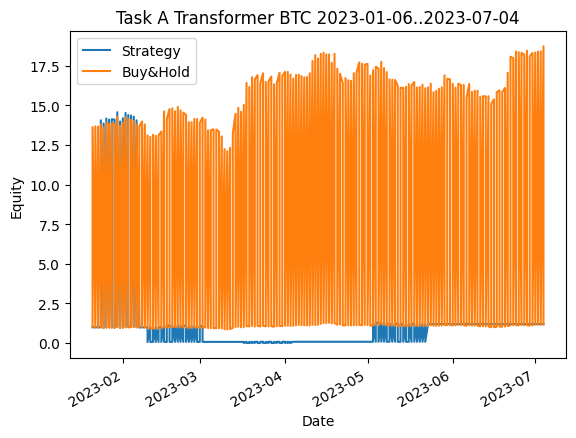

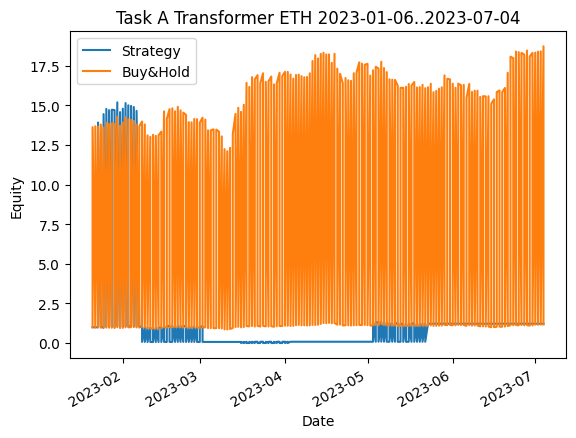

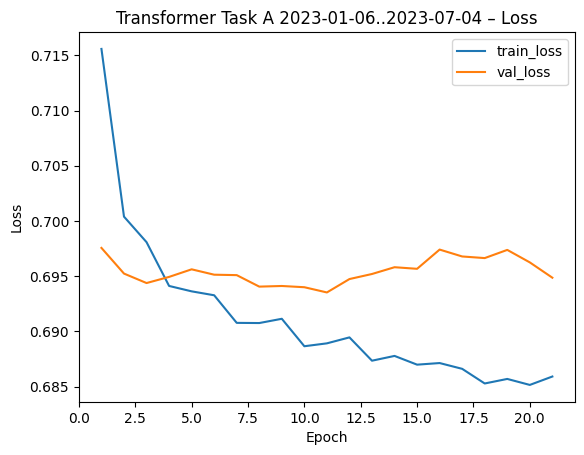

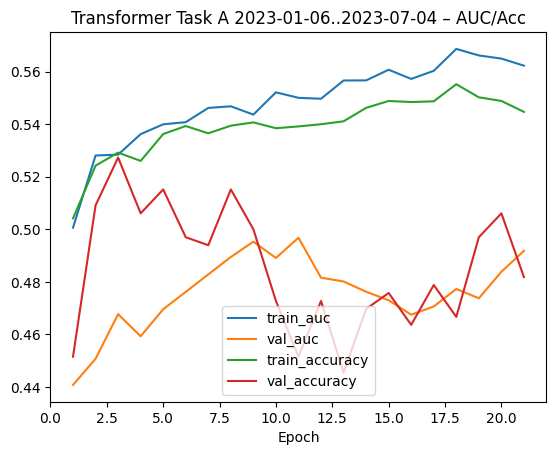


=== Transformer split 2023-07-05..2023-12-31 | Train 7622, Val 360 ===


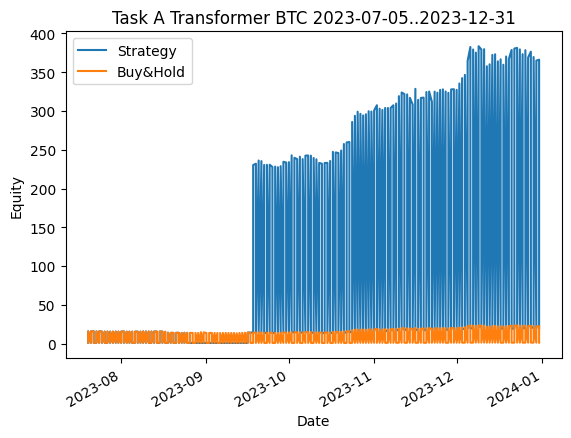

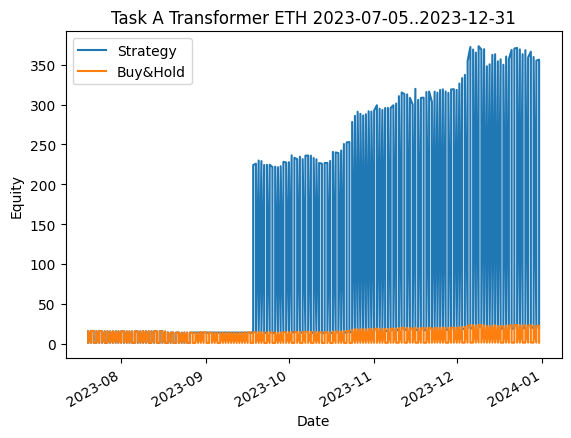

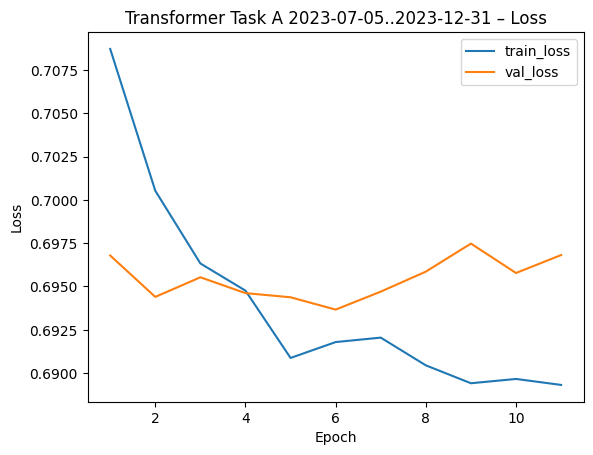

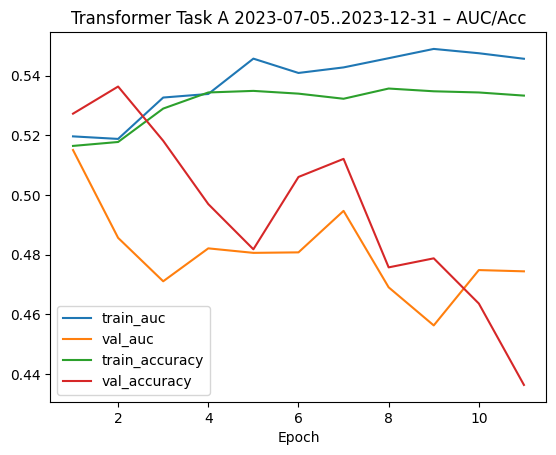


=== Transformer split 2024-01-01..2024-06-28 | Train 7982, Val 360 ===


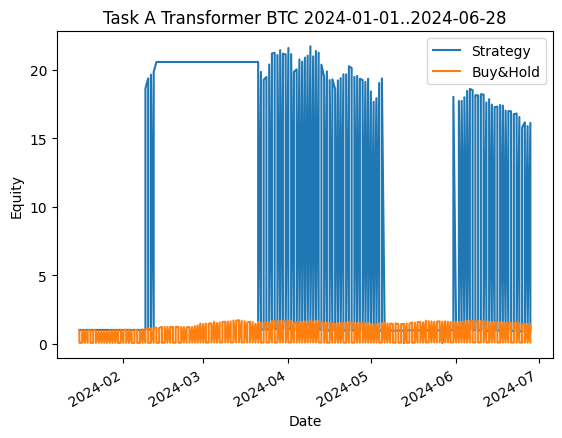

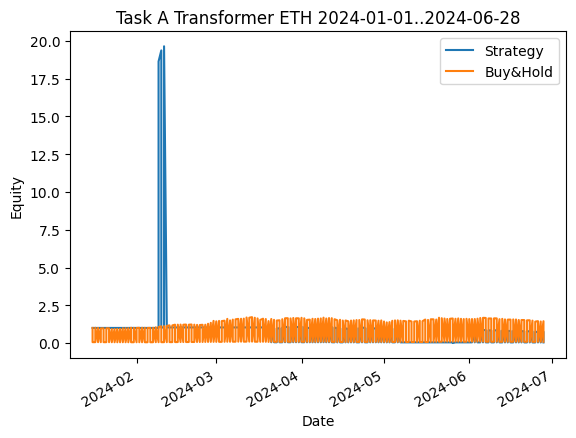

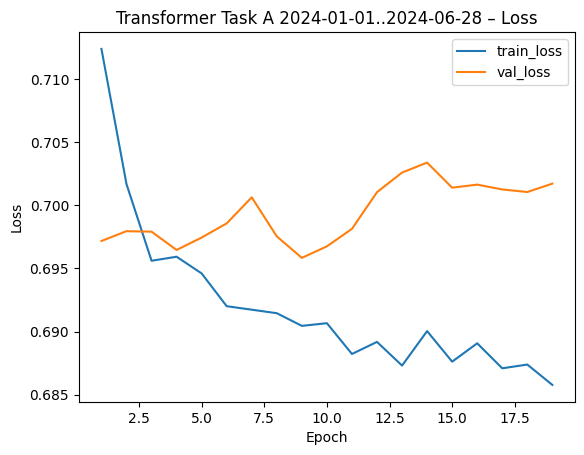

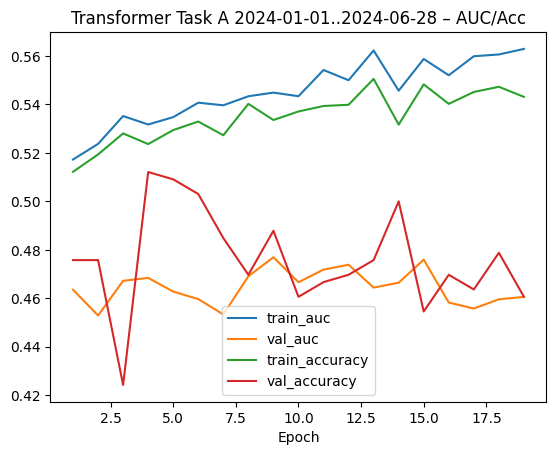


===== TRANSFORMER RESULTS SUMMARY (Task A) ====


task        model coin                    fold       auc       acc  \
0    A  Transformer  BTC  2023-01-06..2023-07-04  0.486772  0.442424   
1    A  Transformer  ETH  2023-01-06..2023-07-04  0.500884  0.460606   
2    A  Transformer  BTC  2023-07-05..2023-12-31  0.533796  0.545455   
3    A  Transformer  ETH  2023-07-05..2023-12-31  0.496615  0.509091   
4    A  Transformer  BTC  2024-01-01..2024-06-28  0.479369  0.496970   
5    A  Transformer  ETH  2024-01-01..2024-06-28  0.480548  0.478788   

      sharpe  equity_end    bh_end  
0   6.776444    1.198365  1.175493  
1   6.908227    1.224843  1.175493  
2  10.422637   20.019981  1.221412  
3  10.422051   19.479233  1.221412  
4   7.193167    0.904780  0.081172  
5   6.978864    0.041907  0.081172

In [ ]:
RUN_TRANSFORMER = True
SEQ_LEN_TRANS = 30
EPOCHS_TRANS   = 30
TOP_VARS_TRANS = 32
trans_results = []

def make_transformer_classifier(seq_len, n_features,
                                num_heads=4,
                                ff_dim=128, dropout=0.2):

    d_model = n_features

    inp = keras.Input(shape=(seq_len, n_features))

    x = layers.LayerNormalization(epsilon=1e-6)(inp)

    attn_output = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=n_features
    )(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    ff = layers.Dense(ff_dim, activation="relu")(x)
    ff = layers.Dropout(dropout)(ff)
    ff = layers.Dense(d_model)(ff)
    x = layers.Add()([x, ff])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(3e-4),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc"), "accuracy"],
    )
    return model

if RUN_TRANSFORMER:
    print("=== TRANSFORMER Task A (next-day direction) ===")
    for (tr_end, vs, ve) in splits:
        tr, va = subset(data, tr_end, vs, ve)
        tr_s, va_s, _ = standardize_train_test(tr, va, feat_cols)
        if len(tr_s) < 500 or len(va_s) < 50:
            print(f"Skipping split {vs.date()}..{ve.date()} (too few rows for Transformer)")
            continue

        print(f"\n=== Transformer split {vs.date()}..{ve.date()} | "f"Train {len(tr_s)}, Val {len(va_s)} ===")

        top_vars_trans = (tr_s[feat_cols].var().sort_values(ascending=False).head(TOP_VARS_TRANS).index.tolist())
        mT, MT = train_eval_seq_model(tr_s, va_s, top_vars_trans,target="y_next_up",epochs=EPOCHS_TRANS,seq_len=SEQ_LEN_TRANS,model_builder=lambda sl, nf: make_transformer_classifier(sl, nf))

        if MT["p"].size == 0:
            continue

        coins_for_transformer_preds = va_s["coin"].iloc[SEQ_LEN_TRANS:]

        for coin in ["BTC", "ETH"]:
            mask = (coins_for_transformer_preds == coin)

            filtered_idx = MT["idx"][mask]
            filtered_p = MT["p"][mask]
            filtered_y = MT["y"][mask]

            if len(filtered_idx) <= 10:
                continue

            close = va.loc[filtered_idx, "close"]
            proba = pd.Series(filtered_p, index=filtered_idx)

            if len(close) > 10:
                auc = (
                    roc_auc_score(filtered_y, filtered_p)
                    if len(np.unique(filtered_y)) > 1 else np.nan
                )
                acc = accuracy_score(
                    filtered_y, (filtered_p > 0.5).astype(int)
                )
                eq, bh, sh = backtest_long_only(close, proba, tau=0.5)
                trans_results.append({
                    "task": "A",
                    "model": "Transformer",
                    "coin": coin,
                    "fold": f"{vs.date()}..{ve.date()}",
                    "auc":  auc,
                    "acc":  acc,
                    "sharpe": sh,
                    "equity_end": float(eq.iloc[-1]),
                    "bh_end": float(bh.iloc[-1]),
                })

                plt.figure()
                eq.plot(label="Strategy")
                bh.plot(label="Buy&Hold")
                plt.legend()
                plt.title(f"Task A Transformer {coin} {vs.date()}..{ve.date()}")
                plt.ylabel("Equity")
                plt.xlabel("Date")
                plt.show()

        if "history" in MT and MT["history"] is not None:
            h = MT["history"]
            epochs_range = range(1, len(h["loss"]) + 1)

            plt.figure()
            plt.plot(epochs_range, h["loss"], label="train_loss")
            plt.plot(epochs_range, h["val_loss"], label="val_loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title(f"Transformer Task A {vs.date()}..{ve.date()} – Loss")
            plt.legend()
            plt.show()

            plt.figure()
            plt.plot(epochs_range, h["auc"], label="train_auc")
            plt.plot(epochs_range, h["val_auc"], label="val_auc")
            plt.plot(epochs_range, h["accuracy"], label="train_accuracy")
            plt.plot(epochs_range, h["val_accuracy"], label="val_accuracy")
            plt.xlabel("Epoch")
            plt.title(f"Transformer Task A {vs.date()}..{ve.date()} – AUC/Acc")
            plt.legend()
            plt.show()

    # small summary table
    trans_res_df = pd.DataFrame(trans_results) if len(trans_results) else pd.DataFrame()
    print("\n===== TRANSFORMER RESULTS SUMMARY (Task A) ====")
    if trans_res_df.empty:
        print("No Transformer results.")
    else:
        display(trans_res_df)

# Transformer (Regression)

=== TRANSFORMER REGRESSION (next_close) ===

=== Transformer REG split 2023-01-06..2023-07-04 | Train 7262, Val 360 ===


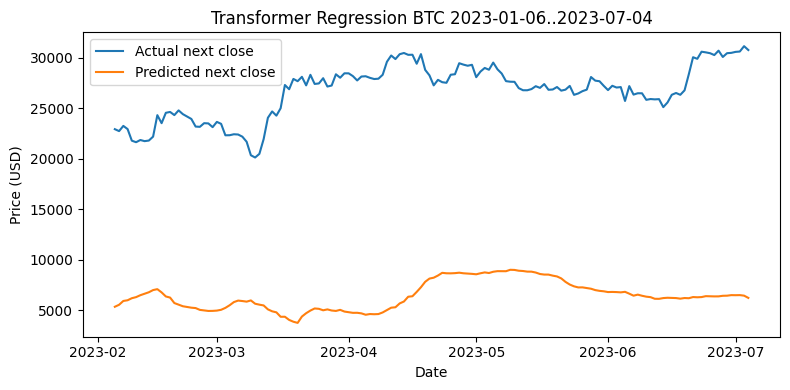

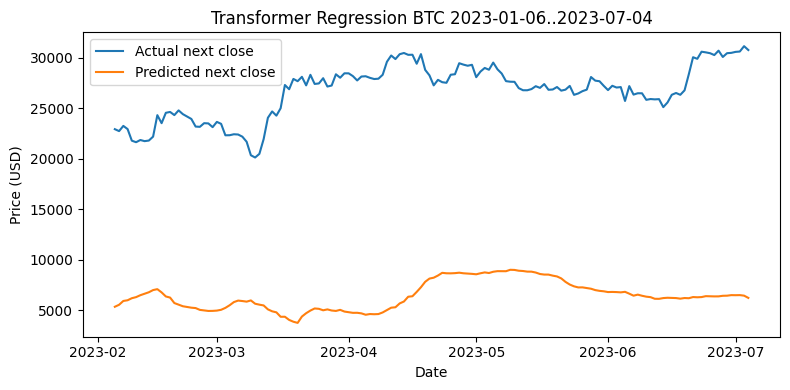

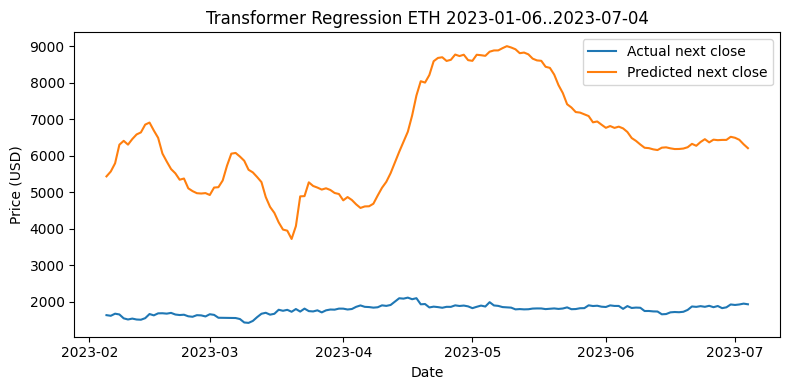

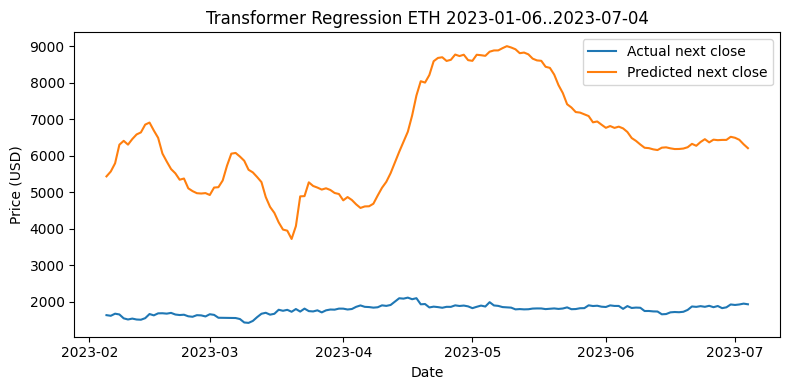

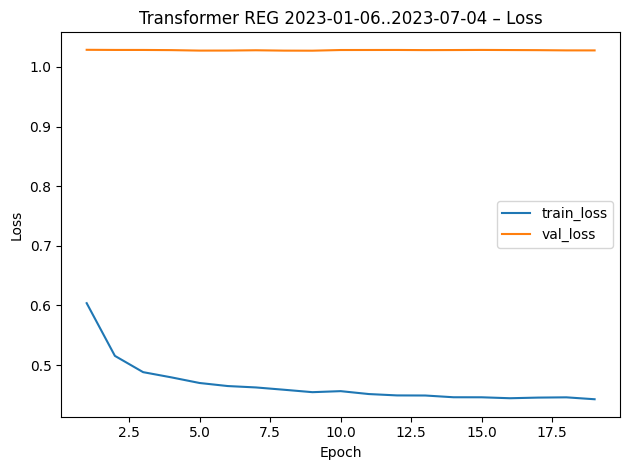

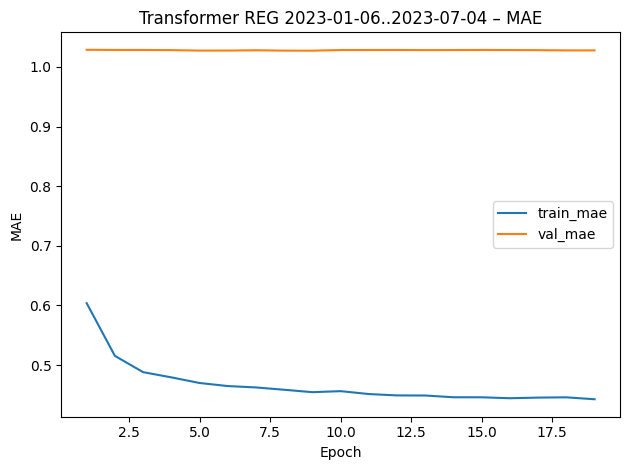


=== Transformer REG split 2023-07-05..2023-12-31 | Train 7622, Val 360 ===


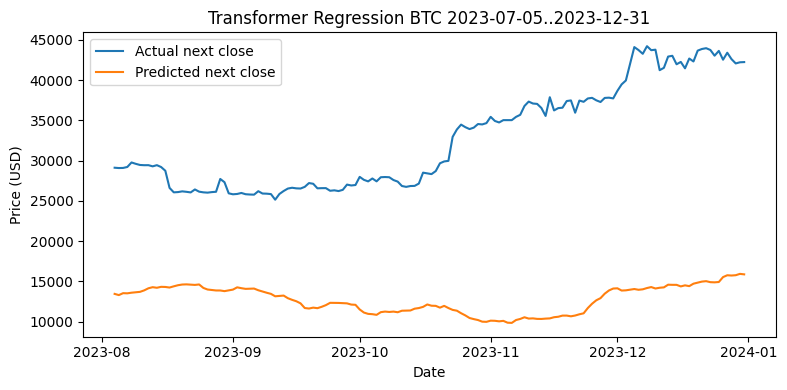

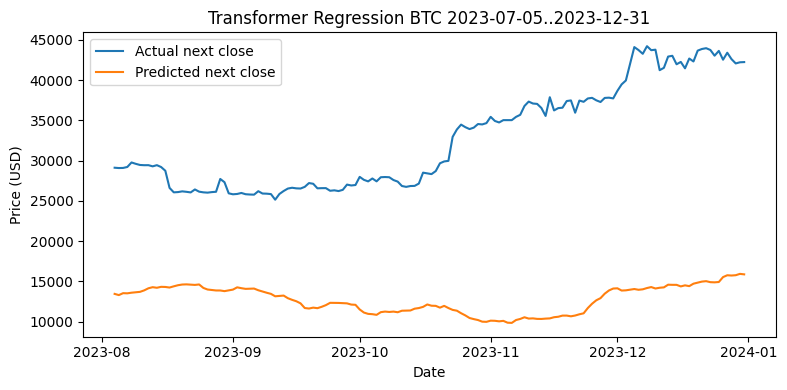

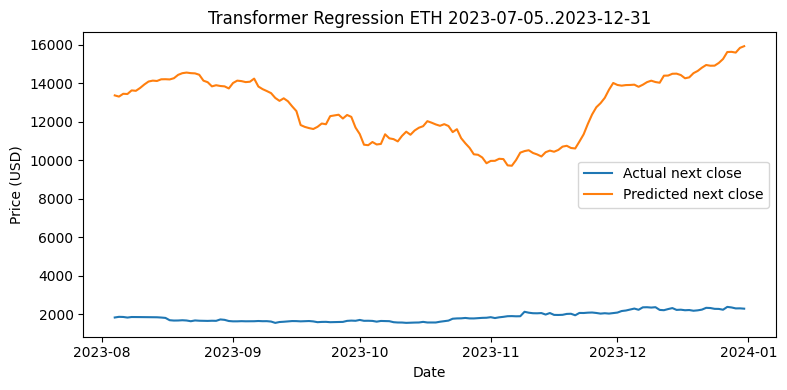

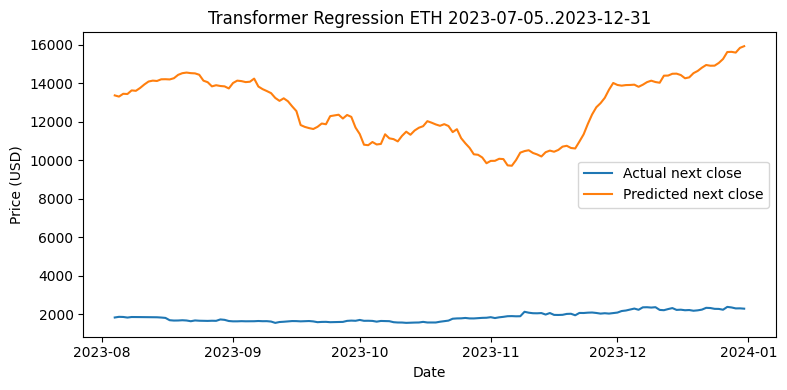

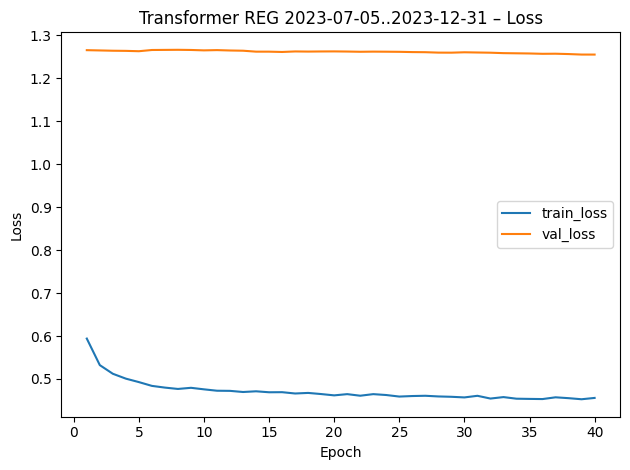

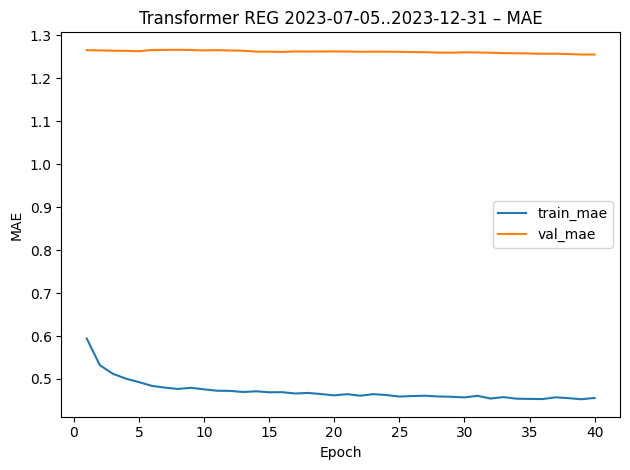


=== Transformer REG split 2024-01-01..2024-06-28 | Train 7982, Val 358 ===


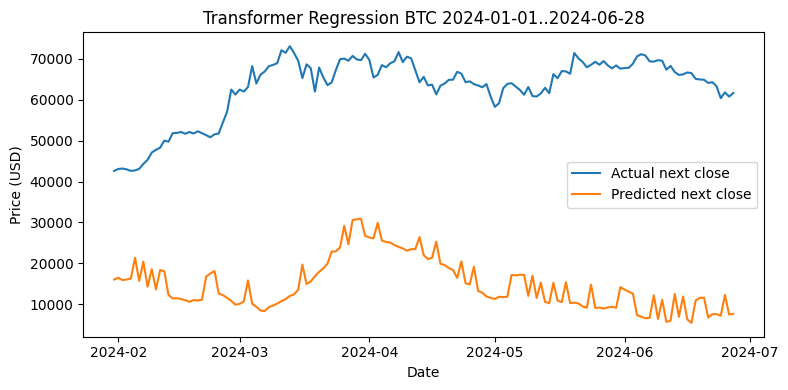

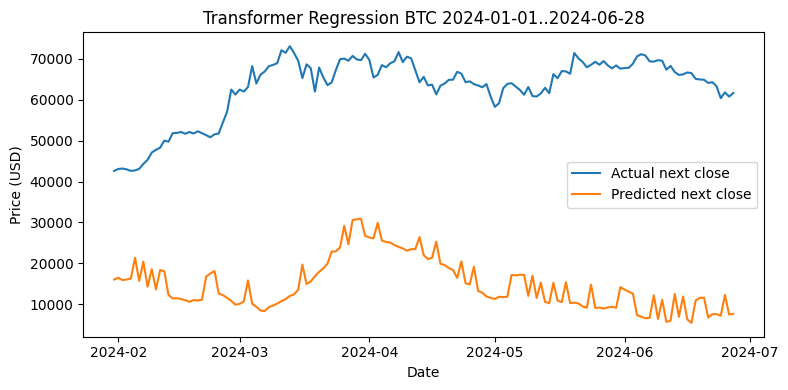

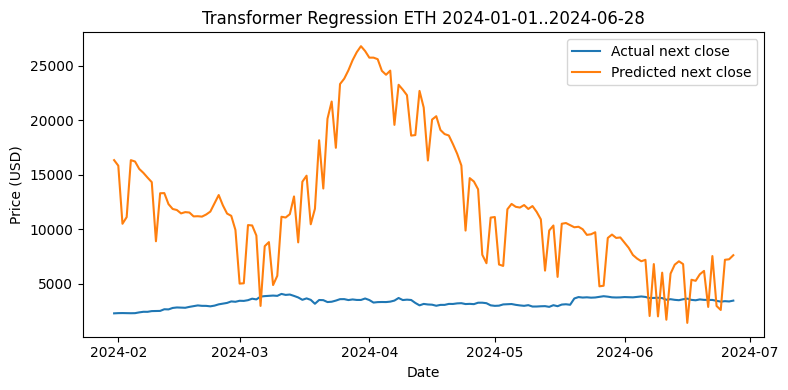

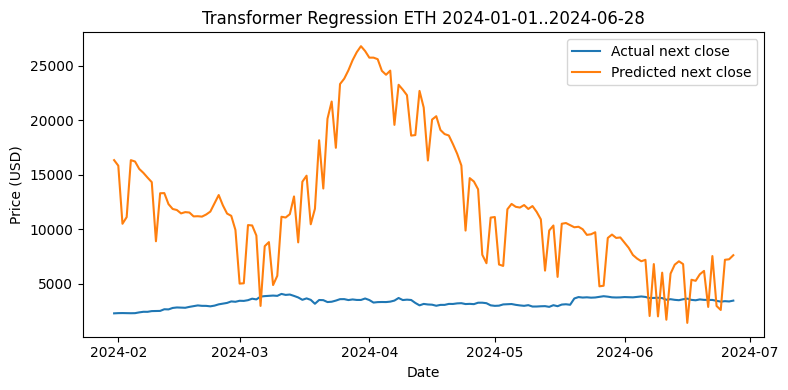

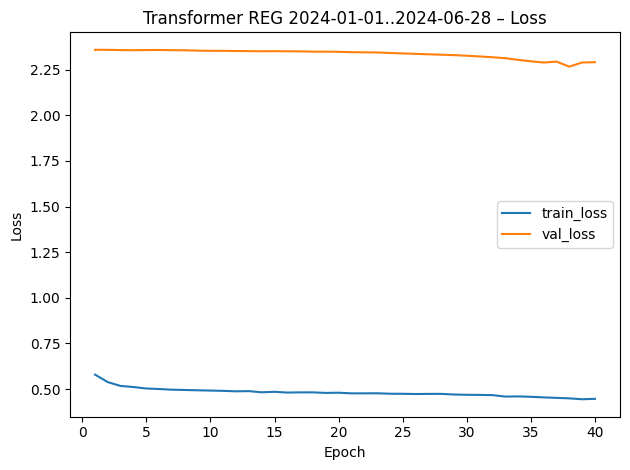

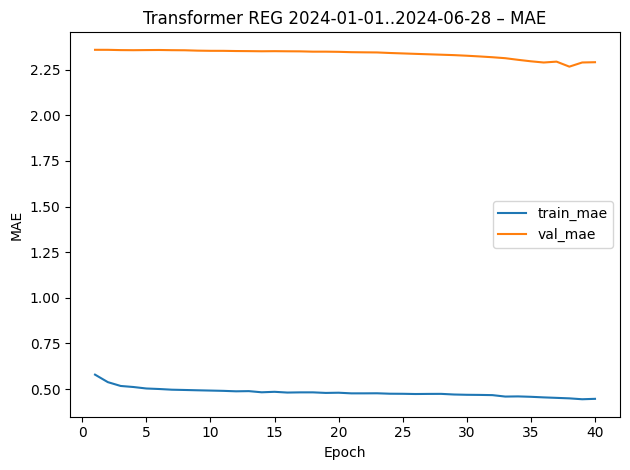


===== TRANSFORMER REGRESSION RESULTS SUMMARY ====


fold           mae          rmse  \
0  2023-01-06..2023-07-04  12468.155273  14851.222172   
1  2023-07-05..2023-12-31  15390.922852  16685.685362   
2  2024-01-01..2024-06-28  28667.705078  35577.254756   

                                                hist  
0  {'loss': [0.6038973927497864, 0.51550948619842...  
1  {'loss': [0.5940439105033875, 0.53223484754562...  
2  {'loss': [0.5791382789611816, 0.53803986310958...

In [ ]:
RUN_TRANSFORMER_REG = True
SEQ_LEN_TRANS_REG   = 60
EPOCHS_TRANS_REG    = 40
TOP_VARS_TRANS_REG  = 32
trans_reg_results   = []

def make_transformer_regressor(seq_len, n_features,
                               d_model=None,
                               num_heads=4,
                               ff_dim=128,
                               dropout=0.2):

    if d_model is None:
        d_model = n_features

    inp = keras.Input(shape=(seq_len, n_features))

    x = layers.LayerNormalization(epsilon=1e-6)(inp)

    attn_output = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=n_features
    )(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    ff = layers.Dense(ff_dim, activation="relu")(x)
    ff = layers.Dropout(dropout)(ff)
    ff = layers.Dense(d_model)(ff)
    x = layers.Add()([x, ff])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation="linear")(x)

    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(3e-4),
        loss="mae",
        metrics=[
            keras.metrics.MeanAbsoluteError(name="mae"),
            keras.metrics.RootMeanSquaredError(name="rmse"),
        ],
    )
    return model


def train_eval_seq_reg(tr, va, feat_cols,
                       target_col="next_close",
                       epochs=35,
                       seq_len=60,
                       model_builder=None):

    if model_builder is None:
        raise ValueError("You must pass a model_builder function")

    Xtr, ytr, _      = make_seq(tr, feat_cols, seq_len, target_col)
    Xva, yva, idx_va = make_seq(va, feat_cols, seq_len, target_col)

    if len(Xtr) == 0 or len(Xva) == 0:
        return None, {
            "mae":  np.nan,
            "rmse": np.nan,
            "p":    np.array([]),
            "y":    np.array([]),
            "idx":  pd.DatetimeIndex([]),
        }

    y_mean = ytr.mean()
    y_std  = ytr.std() + 1e-8
    ytr_s  = (ytr - y_mean) / y_std
    yva_s  = (yva - y_mean) / y_std

    model = model_builder(seq_len, Xtr.shape[-1])

    cb = keras.callbacks.EarlyStopping(
        monitor="val_mae",
        mode="min",
        patience=10,
        restore_best_weights=True,
    )

    history = model.fit(
        Xtr,
        ytr_s,
        epochs=epochs,
        batch_size=128,
        verbose=0,
        validation_data=(Xva, yva_s),
        callbacks=[cb],
    )

    p_s = model.predict(Xva, verbose=0).ravel()
    p   = p_s * y_std + y_mean

    mae  = mean_absolute_error(yva, p)
    rmse = np.sqrt(sk_mse(yva, p))

    return model, {
        "mae": mae,
        "rmse": rmse,
        "p": p,
        "y": yva,
        "idx": idx_va,
        "history": history.history,
    }


if RUN_TRANSFORMER_REG:
    print("=== TRANSFORMER REGRESSION (next_close) ===")

    data_reg = data.copy()
    data_reg["next_close"] = data_reg.groupby("coin")["close"].shift(-1)
    data_reg = data_reg.dropna(subset=["next_close"])

    for (tr_end, vs, ve) in splits:
        tr, va = subset(data_reg, tr_end, vs, ve)
        if len(tr) < 200 or len(va) < 30:
            print(f"Skipping Transformer regression split {vs.date()}..{ve.date()} (too few rows)")
            continue

        tr_s, va_s, _ = standardize_train_test(tr, va, feat_cols)

        print(f"\n=== Transformer REG split {vs.date()}..{ve.date()} | "
              f"Train {len(tr_s)}, Val {len(va_s)} ===")

        top_vars_trans_reg = (
            tr_s[feat_cols].var().sort_values(ascending=False)
            .head(TOP_VARS_TRANS_REG).index.tolist()
        )

        mTR, MTR = train_eval_seq_reg(
            tr_s,
            va_s,
            top_vars_trans_reg,
            target_col="next_close",
            epochs=EPOCHS_TRANS_REG,
            seq_len=SEQ_LEN_TRANS_REG,
            model_builder=lambda sl, nf: make_transformer_regressor(sl, nf),
        )

        if MTR["p"].size == 0:
            continue

        trans_reg_results.append({
            "fold": f"{vs.date()}..{ve.date()}",
            "mae":  MTR["mae"],
            "rmse": MTR["rmse"],
            "hist": MTR["history"],
        })

        coins_for_preds = va["coin"].iloc[SEQ_LEN_TRANS_REG:]
        dates_for_preds = va.index[SEQ_LEN_TRANS_REG:]

        for coin in ["BTC", "ETH"]:
            mask = (coins_for_preds == coin)

            if mask.sum() <= 10:
                continue

            dates_for_coin  = dates_for_preds[mask]
            actual_for_coin = MTR["y"][mask]
            pred_for_coin   = MTR["p"][mask]

            plt.figure(figsize=(8, 4))
            plt.plot(dates_for_coin, actual_for_coin, label="Actual next close")
            plt.plot(dates_for_coin, pred_for_coin,   label="Predicted next close")
            plt.title(f"Transformer Regression {coin} {vs.date()}..{ve.date()}")
            plt.xlabel("Date")
            plt.ylabel("Price (USD)")
            plt.legend()
            plt.tight_layout()
            plt.show()

            if len(dates_for_coin) <= 10:
                continue

            plt.figure(figsize=(8, 4))
            plt.plot(dates_for_coin, actual_for_coin, label="Actual next close")
            plt.plot(dates_for_coin, pred_for_coin,   label="Predicted next close")
            plt.title(f"Transformer Regression {coin} {vs.date()}..{ve.date()}")
            plt.xlabel("Date")
            plt.ylabel("Price (USD)")
            plt.legend()
            plt.tight_layout()
            plt.show()

        if "history" in MTR and MTR["history"] is not None:
            h = MTR["history"]
            epochs_range = range(1, len(h["loss"]) + 1)

            plt.figure()
            plt.plot(epochs_range, h["loss"],     label="train_loss")
            plt.plot(epochs_range, h["val_loss"], label="val_loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title(f"Transformer REG {vs.date()}..{ve.date()} – Loss")
            plt.legend()
            plt.tight_layout()
            plt.show()

            if "mae" in h and "val_mae" in h:
                plt.figure()
                plt.plot(epochs_range, h["mae"],     label="train_mae")
                plt.plot(epochs_range, h["val_mae"], label="val_mae")
                plt.xlabel("Epoch")
                plt.ylabel("MAE")
                plt.title(f"Transformer REG {vs.date()}..{ve.date()} – MAE")
                plt.legend()
                plt.tight_layout()
                plt.show()

    trans_reg_df = pd.DataFrame(trans_reg_results) if len(trans_reg_results) else pd.DataFrame()
    print("\n===== TRANSFORMER REGRESSION RESULTS SUMMARY ====")
    if trans_reg_df.empty:
        print("No Transformer regression results.")
    else:
        display(trans_reg_df)

# Pickle the Results

In [ ]:
import pickle
import os

os.makedirs("./", exist_ok=True)

# with open("./histories_classification_before_stopping.pkl", "wb") as f:
#     pickle.dump(all_histories_cls, f)

# with open("./histories_transformer_classification_new.pkl", "wb") as f:
#     pickle.dump(trans_results, f)

# with open("./histories_classification.pkl", "wb") as f:
#     pickle.dump(all_histories_cls, f)

# with open("./histories_regression_new.pkl", "wb") as f:
#     pickle.dump(all_histories_reg, f)

# with open("./histories_regression_modified_new.pkl", "wb") as f:
#     pickle.dump(all_histories_reg_modified, f)

# with open("./histories_transformer.pkl", "wb") as f:
#     pickle.dump(trans_results, f)

print("Saved histories to ")
!pwd


Saved histories to 
/content/drive/MyDrive/KFUPM Study Material/Term 3 (251 - 2025)/ICS-590/crypto-forecasting-public/big-datasets


# SAVE MERGED FEATURES & RESULTS

In [ ]:
!pwd

/content/drive/MyDrive/KFUPM Study Material/Term 3 (251 - 2025)/ICS-590/crypto-forecasting-public/big-datasets


In [ ]:
OUT_DIR = "./outputs_big_experiment_deep"
os.makedirs(OUT_DIR, exist_ok=True)

data.reset_index().rename(columns={"index": "date"}).to_csv(
    os.path.join(OUT_DIR, "features_merged.csv"), index=False
)

if not res.empty:
    res.to_csv(os.path.join(OUT_DIR, "results_summary.csv"), index=False)

print(f"Saved merged features and results to: {OUT_DIR}")

Saved merged features and results to: ./outputs_big_experiment
